In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.concat([pd.read_csv('rag_model_evaluation_results_orca.csv'),
                pd.read_csv('rag_model_evaluation_results_phi.csv'),
                pd.read_csv('rag_model_evaluation_results_deepseek.csv')])

In [48]:
df.head()

,model_type,model_name,description,parameters,question,context,answer,generation_time,faithfulness_score,relevancy_score,hallucination_score
0,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,What is a collection in Qdrant and what requir...,"Fragment 1 (from collections, similarity: 0.83...",\n\nA collection is a named set of points (vec...,187.553381,9,8,6
1,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,What similarity metrics does Qdrant support fo...,"Fragment 1 (from search, similarity: 0.822):\n...",\n\n,144.500004,4,5,1
2,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,What is the relationship between the choice of...,"Fragment 1 (from collections, similarity: 0.75...",\nThe relationship between the choice of dista...,198.630729,5,10,2
3,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,How does Qdrant implement Cosine similarity fo...,"Fragment 1 (from search, similarity: 0.802):\n...",\nQdrant implements Cosine similarity for sear...,134.886159,7,6,4
4,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,Can collection parameters in Qdrant be modifie...,"Fragment 1 (from collections, similarity: 0.77...",\n Context:\n ...,373.793858,9,4,7


In [49]:
df.loc[df['parameters'] == 'conservative', 'params'] = '{"max_tokens": 500, "temperature": 0.3, "top_k": 40, "top_p": 0.9}'
df.loc[df['parameters'] == 'balanced', 'params'] = '{"max_tokens": 500, "temperature": 0.7, "top_k": 40, "top_p": 0.7}'
df.loc[df['parameters'] == 'creative', 'params'] = '{"max_tokens": 500, "temperature": 1, "top_k": 50, "top_p": 0.4}'

In [51]:
df.groupby(['model_name', 'parameters'], as_index=False).question.nunique()

,model_name,parameters,question
0,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,balanced,327
1,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,conservative,327
2,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,creative,327
3,orca-mini-3b-gguf2-q4_0.gguf,balanced,327
4,orca-mini-3b-gguf2-q4_0.gguf,conservative,327
5,orca-mini-3b-gguf2-q4_0.gguf,creative,327
6,qwen2-1_5b-instruct-q4_0.gguf,balanced,327
7,qwen2-1_5b-instruct-q4_0.gguf,conservative,327
8,qwen2-1_5b-instruct-q4_0.gguf,creative,327


In [52]:
# сколько пустых ответов
df[df['answer'].isin(['\n\n', '\n', '\n \n'])].groupby(['model_name', 'parameters'], as_index=False).question.nunique()

,model_name,parameters,question
0,orca-mini-3b-gguf2-q4_0.gguf,balanced,5
1,orca-mini-3b-gguf2-q4_0.gguf,conservative,3
2,orca-mini-3b-gguf2-q4_0.gguf,creative,6


In [53]:
grouped_df = df.groupby(['model_name', 'params'], as_index=False).agg({
    'faithfulness_score':'mean',
    'relevancy_score':'mean',
    'hallucination_score':'mean',
    'generation_time':'mean'
})

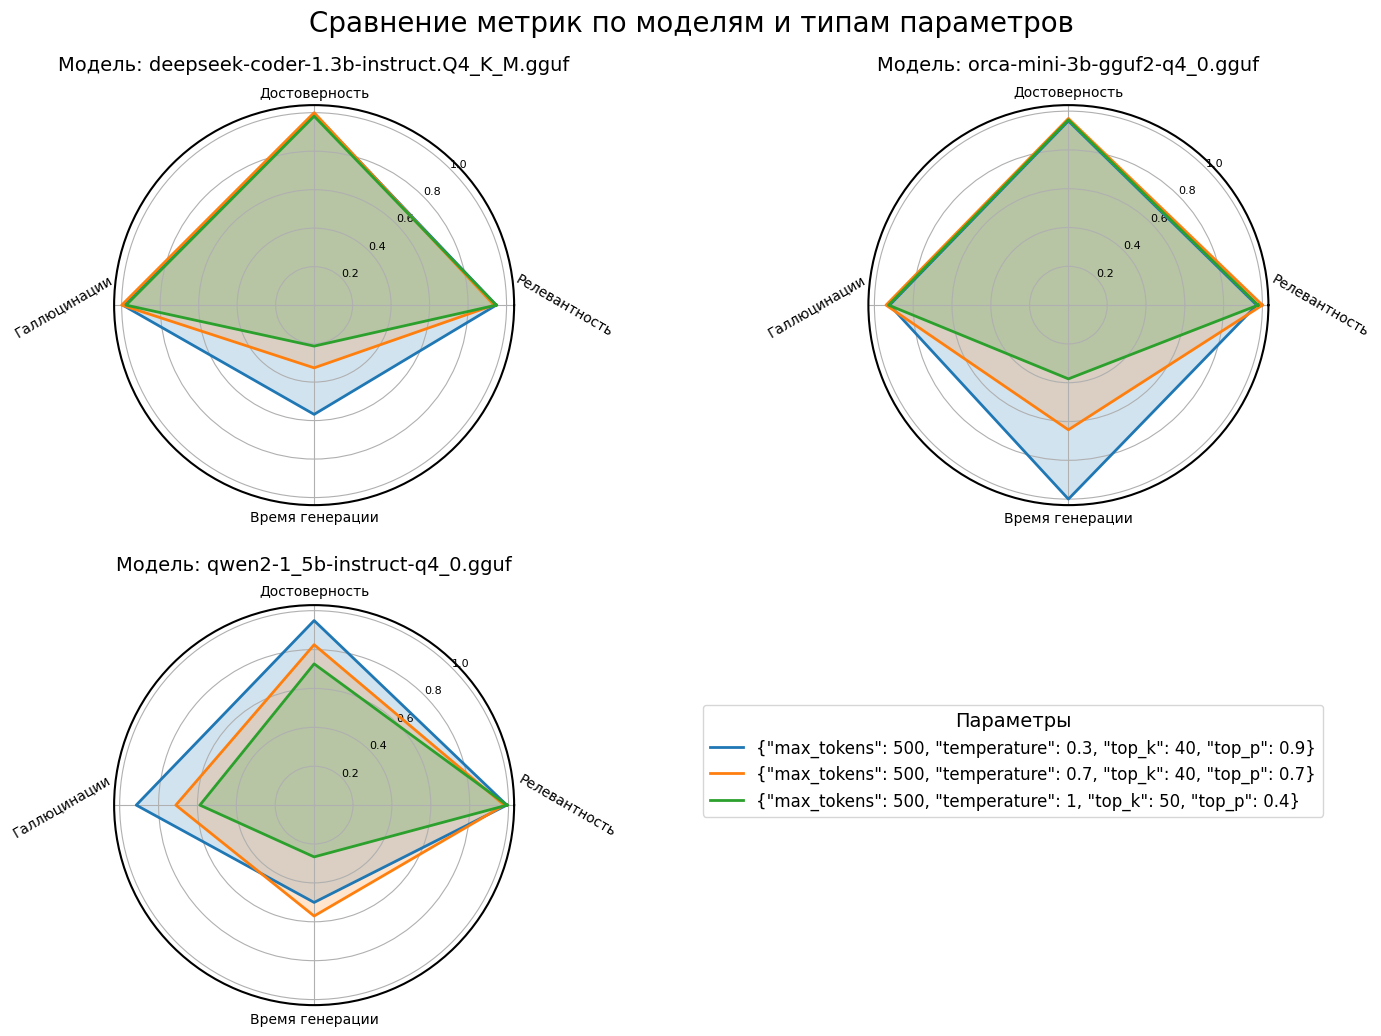

In [54]:
models = grouped_df['model_name'].unique()
params = grouped_df['params'].unique()

# Увеличиваем общий размер фигуры
fig = plt.figure(figsize=(16, 12)) 

# Настраиваем сетку графиков с меньшими отступами
num_models = len(models)
rows = (num_models + 1) // 2  # Количество строк для графиков

# Категории для лучей диаграммы
categories = ['Релевантность', 'Достоверность', 'Галлюцинации', 'Время генерации']
num_cats = len(categories)
angles = np.linspace(0, 2 * np.pi, num_cats, endpoint=False).tolist()
angles += angles[:1]  # Замыкаем круг

# Для общей легенды
param_lines = []
param_labels = []

# Создаем сетку для размещения графиков с указанием пропорций
gs = fig.add_gridspec(rows, 2, wspace=0.1, hspace=0.25, 
                      left=0.05, right=0.95, bottom=0.15, top=0.9)

# Добавляем общий заголовок
fig.suptitle('Сравнение метрик по моделям и типам параметров', fontsize=20, y=0.98)

for i, model in enumerate(models):
    row_idx = i // 2
    col_idx = i % 2
    
    # Используем gridspec для более точного контроля над размерами графиков
    ax = fig.add_subplot(gs[row_idx, col_idx], polar=True)
    
    for j, param in enumerate(params):
        data = grouped_df[(grouped_df['model_name'] == model) & (grouped_df['params'] == param)]
        if not data.empty:
            values = [
                data['relevancy_score'].values[0],
                data['faithfulness_score'].values[0],
                data['hallucination_score'].values[0],
                data['generation_time'].values[0]
            ]
            max_values = grouped_df[['relevancy_score', 'faithfulness_score', 'hallucination_score', 'generation_time']].max()
            normalized_values = [v / m for v, m in zip(values, max_values)]
            normalized_values += normalized_values[:1]  # Замыкаем значения
            
            # Рисуем линию и заливку
            line, = ax.plot(angles, normalized_values, linewidth=2)
            ax.fill(angles, normalized_values, alpha=0.2)
            
            # Сохраняем для легенды только один раз
            if i == 0:
                param_lines.append(line)
                param_labels.append(param)
    
    # Настройка меток осей
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    
    # Размещаем метки категорий с лучшим позиционированием
    ax.text(0, 1.3, 'Релевантность', ha='center', va='center', fontsize=10, rotation=-30, rotation_mode='anchor')
    ax.text(np.pi/2, 1.1, 'Достоверность', ha='center', va='center', fontsize=10)
    ax.text(np.pi, 1.3, 'Галлюцинации', ha='center', va='center', fontsize=10, rotation=30, rotation_mode='anchor')
    ax.text(3*np.pi/2, 1.1, 'Время генерации', ha='center', va='center', fontsize=10)
    
    # Название модели более компактно
    ax.set_title(f'Модель: {model}', pad=25, fontsize=14)
    
    # Настройка радиальных линий и концентрических кругов
    gridlines, labels = ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0], angle=45, fontsize=8)
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# Размещаем легенду внизу по центру для лучшего использования пространства
fig.legend(param_lines, param_labels, loc='lower right', bbox_to_anchor=(0.9, 0.3), fontsize=12, title="Параметры", title_fontsize=14)

plt.show()

Загрузка данных...
Загружено 2943 строк данных


,model_type,model_name,description,parameters,question,context,answer,generation_time,faithfulness_score,relevancy_score,hallucination_score
0,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,What is a collection in Qdrant and what requir...,"Fragment 1 (from collections, similarity: 0.83...",\n\nA collection is a named set of points (vec...,187.553381,9,8,6
1,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,What similarity metrics does Qdrant support fo...,"Fragment 1 (from search, similarity: 0.822):\n...",\n\n,144.500004,4,5,1
2,gpt4all,orca-mini-3b-gguf2-q4_0.gguf,GPT4All Orca Mini 3B,conservative,What is the relationship between the choice of...,"Fragment 1 (from collections, similarity: 0.75...",\nThe relationship between the choice of dista...,198.630729,5,10,2



Настройка необходимых библиотек...

Оценка ответов...
Инициализация BERTScorer...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Инициализация модели для семантического сходства...
Оцениваем все 2943 ответов


Оценка ответов:   0%|          | 0/2943 [00:00<?, ?it/s]


Визуализация результатов...


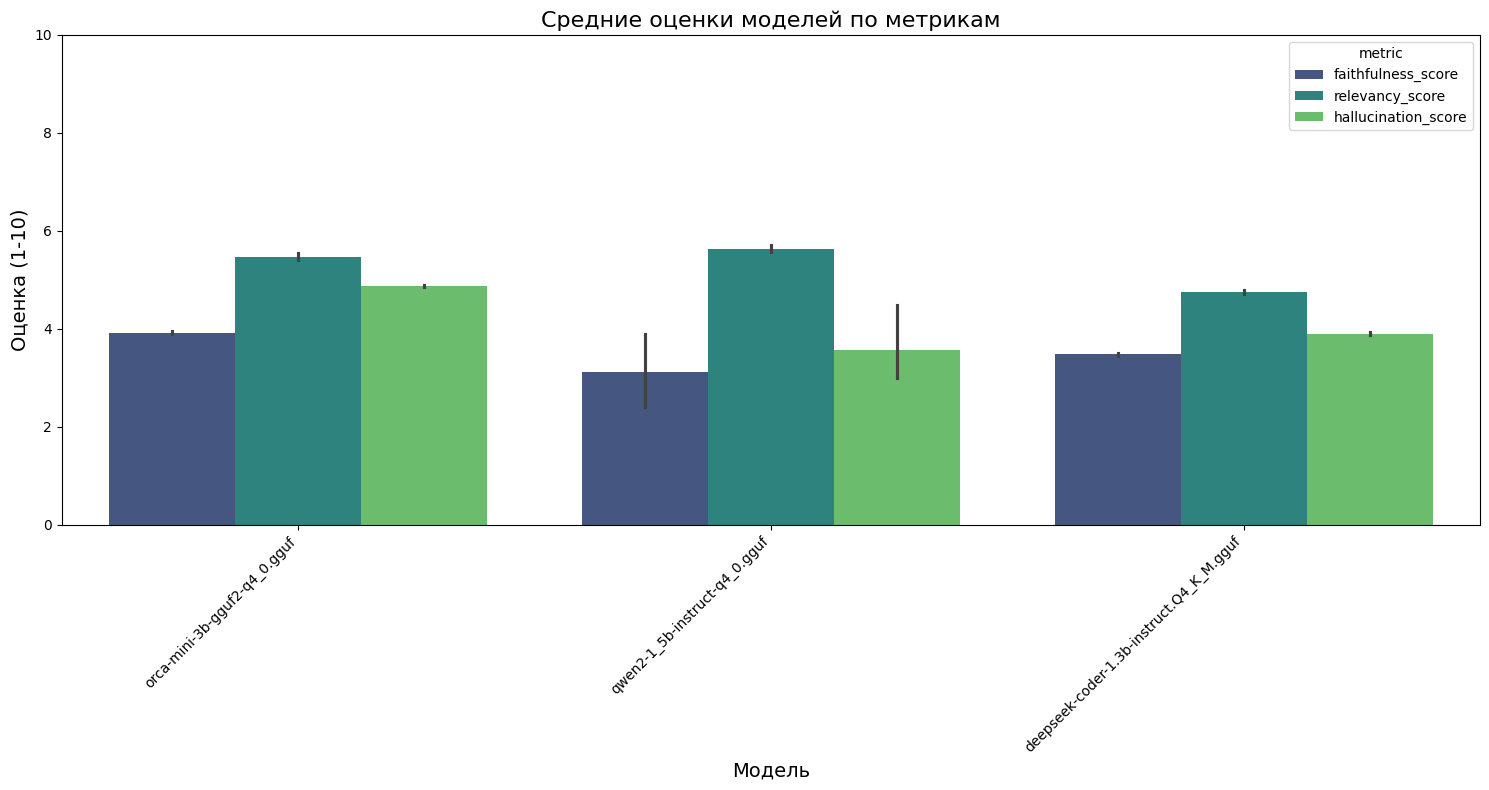

,model_name,parameters,faithfulness_score,relevancy_score,hallucination_score,average_score
5,orca-mini-3b-gguf2-q4_0.gguf,creative,3.96,5.54,4.89,4.80
3,orca-mini-3b-gguf2-q4_0.gguf,balanced,3.91,5.47,4.87,4.75
4,orca-mini-3b-gguf2-q4_0.gguf,conservative,3.90,5.40,4.85,4.72
7,qwen2-1_5b-instruct-q4_0.gguf,conservative,3.90,5.58,4.48,4.65
1,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,conservative,3.50,4.79,3.94,4.08
0,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,balanced,3.47,4.76,3.86,4.03
2,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,creative,3.45,4.70,3.88,4.01
6,qwen2-1_5b-instruct-q4_0.gguf,balanced,3.03,5.56,3.43,4.00
8,qwen2-1_5b-instruct-q4_0.gguf,creative,2.40,5.71,2.79,3.63


<Figure size 1500x1000 with 0 Axes>

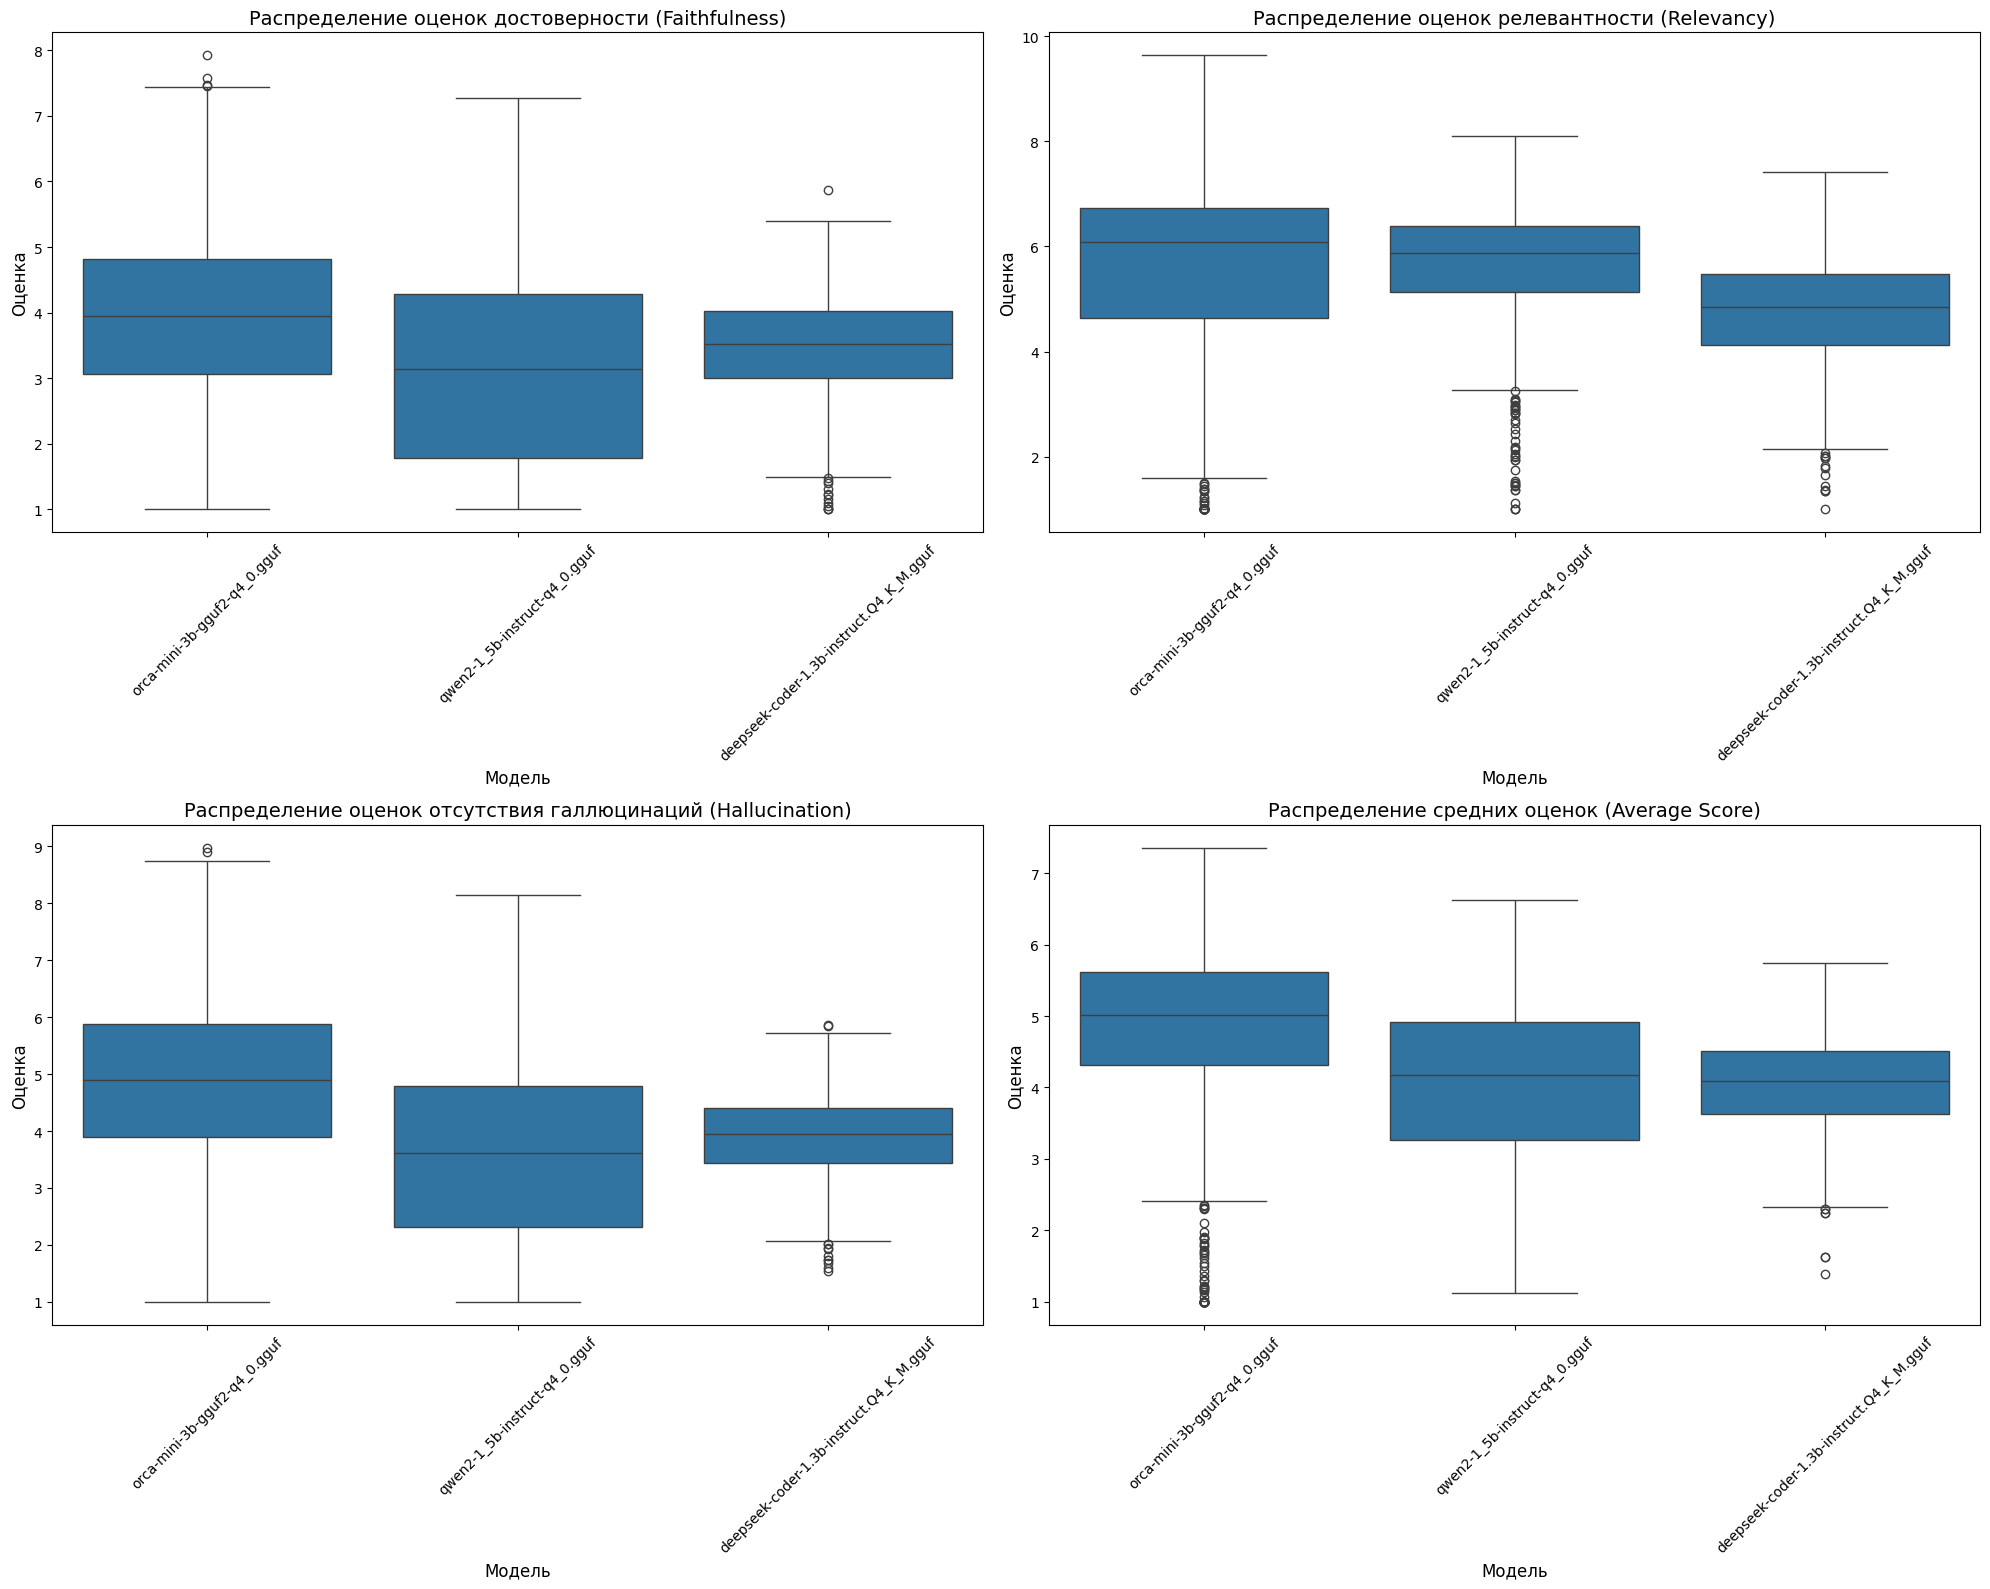

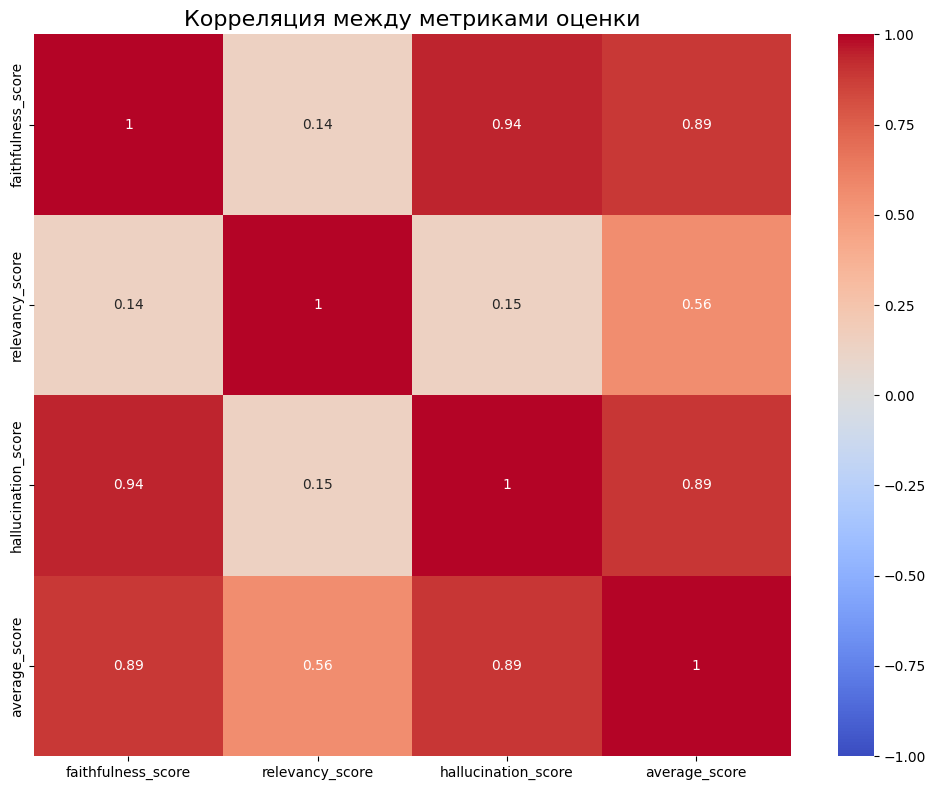


Файл с индексами пропущенных строк не найден.

Анализ завершен! Результаты сохранены в файлах:
- evaluation_results.csv - основные результаты оценки
- evaluation_details.json - детальные метрики для каждого ответа
- model_summary.csv - сводная таблица по моделям
- model_metrics_comparison.png - график сравнения моделей
- score_distributions.png - распределения оценок
- metrics_correlation.png - корреляция между метриками


In [66]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import nltk
import re
import json
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer

# Загрузка данных
def load_data():
    try:
        df = pd.concat([
            pd.read_csv('rag_model_evaluation_results_orca.csv'),
            pd.read_csv('rag_model_evaluation_results_phi.csv'),
            pd.read_csv('rag_model_evaluation_results_deepseek.csv')
        ])
        
        print(f"Загружено {len(df)} строк данных")
        display(df.head(3))
        return df
    except Exception as e:
        print(f"Ошибка при загрузке данных: {str(e)}")
        # Если файлы не найдены, создаем пустой датафрейм для тестирования
        return pd.DataFrame({
            'question': ['Test question'],
            'answer': ['Test answer'],
            'context': ['Test context'],
            'model_name': ['Test model'],
            'parameters': ['Test params']
        })

# Убедимся, что у нас есть все нужные библиотеки
def setup_nltk():
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('punkt')
        nltk.download('stopwords')

    from nltk.corpus import stopwords
    return set(stopwords.words('english'))

# 1. BERTScore для оценки семантического соответствия
def setup_bert_scorer():
    print("Инициализация BERTScorer...")
    try:
        from bert_score import BERTScorer
        # Используем модель RoBERTa для английского текста
        scorer = BERTScorer(
            lang="en", 
            rescale_with_baseline=True,
            model_type="roberta-large"
        )
        return scorer
    except ImportError:
        print("Установка bert_score...")
        os.system("pip install bert_score -q")
        from bert_score import BERTScorer
        scorer = BERTScorer(
            lang="en", 
            rescale_with_baseline=True,
            model_type="roberta-large"
        )
        return scorer
    except Exception as e:
        print(f"Ошибка при инициализации BERTScorer: {str(e)}")
        return None

# 2. Установка Sentence Transformers для семантического сходства
def setup_semantic_model():
    print("Инициализация модели для семантического сходства...")
    try:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('all-MiniLM-L6-v2')
        return model
    except ImportError:
        print("Установка sentence-transformers...")
        os.system("pip install sentence-transformers -q")
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('all-MiniLM-L6-v2')
        return model
    except Exception as e:
        print(f"Ошибка при инициализации SentenceTransformer: {str(e)}")
        return None

# 3. Функции для обработки текста
def preprocess_text(text):
    """Базовая предобработка текста"""
    if not isinstance(text, str):
        return ""
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем спецсимволы
    text = re.sub(r'[^\w\s]', '', text)
    # Токенизируем
    tokens = nltk.word_tokenize(text)
    # Убираем стоп-слова
    stop_words = setup_nltk()
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def compute_semantic_similarity(text1, text2, model):
    """Вычисление семантического сходства между двумя текстами"""
    try:
        if not text1 or not text2 or not model:
            return 0.5  # Нейтральная оценка если нет данных или модели
            
        # Кодируем тексты в векторы
        embedding1 = model.encode(text1)
        embedding2 = model.encode(text2)
        
        # Вычисляем косинусное сходство
        similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
        return float(similarity)  # Преобразуем в обычный float для безопасной сериализации
    except Exception as e:
        print(f"Ошибка при вычислении семантического сходства: {str(e)}")
        return 0.5  # Нейтральная оценка при ошибке

def extract_ngrams(text, n=2):
    """Извлечение n-грамм из текста"""
    try:
        tokens = nltk.word_tokenize(text.lower())
        ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        return ngrams
    except:
        return []

def detect_numerical_hallucinations(answer, context):
    """Обнаружение числовых галлюцинаций"""
    try:
        if not answer or not context:
            return 0.5  # Нейтральная оценка при пустых данных
            
        # Найти все числа в ответе и контексте
        numbers_in_answer = set(re.findall(r'\b\d+(?:\.\d+)?\b', str(answer).lower()))
        numbers_in_context = set(re.findall(r'\b\d+(?:\.\d+)?\b', str(context).lower()))
        
        # Если в ответе нет чисел, вернуть нейтральную оценку
        if not numbers_in_answer:
            return 0.7
        
        # Проверить, сколько чисел из ответа есть в контексте
        unsupported_numbers = len(numbers_in_answer - numbers_in_context)
        
        # Вычислить долю подтвержденных чисел
        support_score = 1.0 - (unsupported_numbers / len(numbers_in_answer))
        
        return float(support_score)  # Преобразуем в обычный float
    except Exception as e:
        print(f"Ошибка при обнаружении числовых галлюцинаций: {str(e)}")
        return 0.5  # Нейтральная оценка при ошибке

def analyze_factual_coverage(answer, context):
    """Анализ покрытия фактов из контекста"""
    try:
        if not answer or not context:
            return 0.5  # Нейтральная оценка при пустых данных
            
        # Предобработка
        processed_answer = preprocess_text(answer)
        processed_context = preprocess_text(context)
        
        if not processed_answer or not processed_context:
            return 0.5
            
        # Создаем TF-IDF векторизатор
        tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
        tfidf.fit([processed_context])
        
        # Получаем важные термины из контекста
        context_vector = tfidf.transform([processed_context]).toarray()[0]
        answer_vector = tfidf.transform([processed_answer]).toarray()[0]
        
        # Проверяем, сколько значимых термов из контекста есть в ответе
        feature_names = tfidf.get_feature_names_out()
        important_terms = [(feature_names[i], context_vector[i]) for i in range(len(feature_names)) if context_vector[i] > 0.01]
        important_terms.sort(key=lambda x: x[1], reverse=True)
        
        # Берем топ-50 важных термов или меньше, если их меньше 50
        top_term_count = min(50, len(important_terms))
        top_terms = [term for term, score in important_terms[:top_term_count]]
        
        if not top_terms:
            return 0.5
            
        # Проверяем сколько из них есть в ответе
        coverage = sum(1 for term in top_terms if term in processed_answer) / len(top_terms)
        
        return float(coverage)  # Преобразуем в обычный float
    except Exception as e:
        print(f"Ошибка при анализе факт. покрытия: {str(e)}")
        # Запасной вариант, если TF-IDF не сработал
        try:
            processed_answer = preprocess_text(answer)
            processed_context = preprocess_text(context)
            answer_tokens = set(processed_answer.split())
            context_tokens = set(processed_context.split())
            overlap = len(answer_tokens.intersection(context_tokens)) / max(1, len(answer_tokens))
            return float(overlap)  # Преобразуем в обычный float
        except:
            return 0.5  # Нейтральная оценка при ошибке

# 4. Функции оценки для каждой метрики
def evaluate_faithfulness(answer, context, bert_scorer, semantic_model):
    """Оценка достоверности ответа (faithfulness)"""
    try:
        if not answer or not context:
            return {'score': 5.0, 'details': {'note': 'Empty answer or context'}}
        
        # 1. Семантическое сходство с помощью BERTScore
        bertscore_f1 = 0.5  # Значение по умолчанию
        if bert_scorer:
            try:
                P, R, F1 = bert_scorer.score([str(answer)[:1000]], [str(context)[:2000]])
                bertscore_f1 = float(F1.item())  # Преобразуем в обычный float
            except Exception as e:
                print(f"Ошибка BERTScore в faithfulness: {str(e)}")
        
        # 2. Семантическое сходство с помощью Sentence Transformers
        semantic_similarity = compute_semantic_similarity(str(answer)[:500], str(context)[:1000], semantic_model)
        
        # 3. Покрытие фактов
        factual_coverage = analyze_factual_coverage(answer, context)
        
        # 4. Обнаружение числовых галлюцинаций
        numerical_consistency = detect_numerical_hallucinations(answer, context)
        
        # Комбинируем метрики с весами
        combined_score = (
            0.35 * bertscore_f1 + 
            0.3 * semantic_similarity + 
            0.25 * factual_coverage + 
            0.1 * numerical_consistency
        )
        
        # Преобразуем в шкалу 1-10
        score = 1 + 9 * combined_score
        score = min(10, max(1, score))
        
        return {
            'score': float(score),  # Преобразуем в обычный float
            'details': {
                'bertscore_f1': float(bertscore_f1),
                'semantic_similarity': float(semantic_similarity),
                'factual_coverage': float(factual_coverage),
                'numerical_consistency': float(numerical_consistency)
            }
        }
    except Exception as e:
        print(f"Ошибка общая в faithfulness: {str(e)}")
        return {
            'score': 5.0,  # Нейтральная оценка при ошибке
            'details': {
                'bertscore_f1': 0.0,
                'semantic_similarity': 0.0,
                'factual_coverage': 0.0,
                'numerical_consistency': 0.0,
                'error': str(e)
            }
        }

def evaluate_relevancy(answer, question, bert_scorer, semantic_model):
    """Оценка релевантности ответа (answer_relevancy)"""
    try:
        if not answer or not question:
            return {'score': 5.0, 'details': {'note': 'Empty answer or question'}}
        
        # 1. Семантическое сходство с помощью BERTScore
        bertscore_f1 = 0.5  # Значение по умолчанию
        if bert_scorer:
            try:
                P, R, F1 = bert_scorer.score([str(answer)[:500]], [str(question)])
                bertscore_f1 = float(F1.item())  # Преобразуем в обычный float
            except Exception as e:
                print(f"Ошибка BERTScore в relevancy: {str(e)}")
        
        # 2. Семантическое сходство с помощью Sentence Transformers
        semantic_similarity = compute_semantic_similarity(str(answer)[:500], str(question), semantic_model)
        
        # 3. Проверка ключевых слов из вопроса
        stop_words = setup_nltk()
        processed_question = preprocess_text(question)
        processed_answer = preprocess_text(answer[:500])
        
        question_keywords = [word for word in processed_question.split() 
                            if word not in stop_words and len(word) > 2]
        
        keyword_coverage = 0.5  # Значение по умолчанию
        if question_keywords:
            answer_tokens = set(processed_answer.split())
            keyword_coverage = sum(1 for kw in question_keywords if kw in answer_tokens) / len(question_keywords)
        
        # 4. Проверка соответствия типу вопроса
        question_type_match = 0.6  # Нейтральная оценка по умолчанию
        q_lower = str(question).lower()
        a_lower = str(answer).lower()
        
        if any(q_lower.startswith(w) for w in ["how ", "how-", "in what way"]):
            if any(a_lower.startswith(w) for w in ["by ", "through ", "using ", "with ", "you can "]):
                question_type_match = 0.9
        elif any(q_lower.startswith(w) for w in ["what is", "what are", "what's", "define"]):
            if any(a_lower.startswith(w) for w in ["it is", "these are", "this is", "a ", "the "]):
                question_type_match = 0.9
        elif any(q_lower.startswith(w) for w in ["why "]):
            if any(a_lower.startswith(w) for w in ["because", "since", "due to", "the reason"]):
                question_type_match = 0.9
        
        # Комбинируем метрики с весами
        combined_score = (
            0.4 * bertscore_f1 + 
            0.3 * semantic_similarity + 
            0.2 * keyword_coverage + 
            0.1 * question_type_match
        )
        
        # Преобразуем в шкалу 1-10
        score = 1 + 9 * combined_score
        score = min(10, max(1, score))
        
        return {
            'score': float(score),  # Преобразуем в обычный float
            'details': {
                'bertscore_f1': float(bertscore_f1),
                'semantic_similarity': float(semantic_similarity),
                'keyword_coverage': float(keyword_coverage),
                'question_type_match': float(question_type_match)
            }
        }
    except Exception as e:
        print(f"Ошибка общая в relevancy: {str(e)}")
        return {
            'score': 5.0,  # Нейтральная оценка при ошибке
            'details': {
                'bertscore_f1': 0.0,
                'semantic_similarity': 0.0,
                'keyword_coverage': 0.0,
                'question_type_match': 0.0,
                'error': str(e)
            }
        }

def evaluate_hallucination(answer, context, bert_scorer, semantic_model):
    """Оценка наличия галлюцинаций (hallucination)"""
    try:
        if not answer or not context:
            return {'score': 5.0, 'details': {'note': 'Empty answer or context'}}
        
        # 1. Семантическое сходство с контекстом (выше сходство = меньше галлюцинаций)
        semantic_similarity = compute_semantic_similarity(str(answer)[:500], str(context)[:1000], semantic_model)
        
        # 2. Проверка n-грамм из ответа в контексте
        answer_bigrams = extract_ngrams(str(answer), n=2)
        answer_trigrams = extract_ngrams(str(answer), n=3)
        context_text = ' '.join(nltk.word_tokenize(str(context).lower()))
        
        bigram_support = 0.5  # Значение по умолчанию
        if answer_bigrams:
            bigram_in_context = sum(1 for bg in answer_bigrams if bg in context_text)
            bigram_support = bigram_in_context / len(answer_bigrams)
            
        trigram_support = 0.5  # Значение по умолчанию
        if answer_trigrams:
            trigram_in_context = sum(1 for tg in answer_trigrams if tg in context_text)
            trigram_support = trigram_in_context / len(answer_trigrams)
        
        # Взвешенная оценка n-грамм
        ngram_support = 0.4 * bigram_support + 0.6 * trigram_support
        
        # 3. Фактическое покрытие
        factual_coverage = analyze_factual_coverage(answer, context)
        
        # 4. Числовая согласованность
        numerical_consistency = detect_numerical_hallucinations(answer, context)
        
        # 5. BERTScore для дополнительной проверки
        bertscore_precision = 0.5  # Значение по умолчанию
        if bert_scorer:
            try:
                P, R, F1 = bert_scorer.score([str(answer)[:500]], [str(context)[:1000]])
                bertscore_precision = float(P.item())  # Преобразуем в обычный float
            except Exception as e:
                print(f"Ошибка BERTScore в hallucination: {str(e)}")
            
        # Комбинируем метрики с весами (высокий балл = меньше галлюцинаций)
        combined_score = (
            0.25 * semantic_similarity + 
            0.25 * ngram_support + 
            0.2 * factual_coverage +
            0.15 * numerical_consistency +
            0.15 * bertscore_precision
        )
        
        # Преобразуем в шкалу 1-10
        score = 1 + 9 * combined_score
        score = min(10, max(1, score))
        
        return {
            'score': float(score),
            'details': {
                'semantic_similarity': float(semantic_similarity),
                'ngram_support': float(ngram_support),
                'factual_coverage': float(factual_coverage),
                'numerical_consistency': float(numerical_consistency),
                'bertscore_precision': float(bertscore_precision)
            }
        }
    except Exception as e:
        print(f"Ошибка общая в hallucination: {str(e)}")
        return {
            'score': 5.0,  # Нейтральная оценка при ошибке
            'details': {
                'semantic_similarity': 0.0,
                'ngram_support': 0.0,
                'factual_coverage': 0.0,
                'numerical_consistency': 0.0,
                'bertscore_precision': 0.0,
                'error': str(e)
            }
        }

# Основная функция для оценки всего датасета
def evaluate_dataset(df, sample=None):
    """Оценка ответов в датасете по трем метрикам"""
    # Инициализируем модели
    bert_scorer = setup_bert_scorer()
    semantic_model = setup_semantic_model()
    
    # Возьмем подвыборку, если указано
    if sample and sample < len(df):
        eval_df = df.sample(sample, random_state=42)
        print(f"Оцениваем выборку из {sample} ответов")
    else:
        eval_df = df
        print(f"Оцениваем все {len(df)} ответов")
    
    # Подготовим список для результатов
    results = []
    skipped_indices = []
    
    # Оцениваем каждую строку
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Оценка ответов"):
        try:
            # Безопасное получение данных
            answer = str(row.get('answer', ''))
            question = str(row.get('question', ''))
            context = str(row.get('context', ''))
            model_name = str(row.get('model_name', row.get('description', 'unknown')))
            parameters = str(row.get('parameters', 'unknown'))
            
            # Проверяем наличие необходимых данных
            if not answer or not question or not context:
                print(f"Предупреждение: строка {idx} содержит пустые данные")
                # Не пропускаем строки с пустыми данными, а оцениваем их с нейтральными значениями
            
            # Оцениваем по трем метрикам
            faith_result = evaluate_faithfulness(answer, context, bert_scorer, semantic_model)
            relev_result = evaluate_relevancy(answer, question, bert_scorer, semantic_model)
            hallu_result = evaluate_hallucination(answer, context, bert_scorer, semantic_model)
            
            # Вычисляем средний балл
            avg_score = (faith_result['score'] + relev_result['score'] + hallu_result['score']) / 3
            
            # Сохраняем результаты
            result = {
                'idx': idx,
                'model_name': model_name,
                'parameters': parameters,
                'question': question,
                'answer': answer,
                'context': context,
                'faithfulness_score': faith_result['score'],
                'relevancy_score': relev_result['score'],
                'hallucination_score': hallu_result['score'],
                'average_score': avg_score,
                'details': {
                    'faithfulness': faith_result['details'],
                    'relevancy': relev_result['details'],
                    'hallucination': hallu_result['details']
                }
            }
            
            results.append(result)
            
            # Каждые 10 оценок сохраняем промежуточные результаты
            if len(results) % 10 == 0:
                temp_df = pd.DataFrame([{
                    'idx': r['idx'],
                    'model_name': r['model_name'],
                    'parameters': r['parameters'],
                    'question': r['question'],
                    'answer': r['answer'],
                    'context': r['context'],
                    'faithfulness_score': r['faithfulness_score'],
                    'relevancy_score': r['relevancy_score'],
                    'hallucination_score': r['hallucination_score'],
                    'average_score': r['average_score']
                } for r in results])
                
                temp_df.to_csv('evaluation_results_intermediate.csv', index=False)
                
        except Exception as e:
            print(f"Ошибка при оценке строки {idx}: {str(e)}")
            skipped_indices.append(idx)
            
            # Даже при ошибке добавляем запись с нулевыми оценками, чтобы не потерять строку
            try:
                result = {
                    'idx': idx,
                    'model_name': str(row.get('model_name', row.get('description', 'unknown'))),
                    'parameters': str(row.get('parameters', 'unknown')),
                    'question': str(row.get('question', '')),
                    'answer': str(row.get('answer', '')),
                    'context': str(row.get('context', '')),
                    'faithfulness_score': 0.0,
                    'relevancy_score': 0.0,
                    'hallucination_score': 0.0,
                    'average_score': 0.0,
                    'details': {
                        'error': str(e)
                    }
                }
                results.append(result)
            except:
                print(f"Не удалось создать запись с нулями для строки {idx}")
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame([{
        'idx': r['idx'],
        'model_name': r['model_name'],
        'parameters': r['parameters'],
        'question': r['question'],
        'answer': r['answer'],
        'context': r['context'],
        'faithfulness_score': r['faithfulness_score'],
        'relevancy_score': r['relevancy_score'],
        'hallucination_score': r['hallucination_score'],
        'average_score': r['average_score']
    } for r in results])
    
    # Сохраняем детали в отдельный файл JSON
    with open('evaluation_details.json', 'w') as f:
        json.dump([{
            'idx': r['idx'],
            'details': r['details']
        } for r in results], f, ensure_ascii=False, indent=2)
    
    # Сохраняем результаты
    results_df.to_csv('evaluation_results.csv', index=False)
    
    # Сохраняем индексы строк с ошибками
    if skipped_indices:
        print(f"При обработке {len(skipped_indices)} строк возникли ошибки. Сохраняем их индексы.")
        with open('skipped_indices.json', 'w') as f:
            json.dump(skipped_indices, f)
    
    return results_df

# Функция для визуализации результатов
def visualize_results(results_df):
    """Визуализация результатов оценки"""
    # Подготовка данных
    model_scores = results_df.groupby(['model_name', 'parameters']).agg({
        'faithfulness_score': 'mean',
        'relevancy_score': 'mean',
        'hallucination_score': 'mean',
        'average_score': 'mean'
    }).reset_index()
    
    # Сортируем по среднему баллу
    model_scores = model_scores.sort_values('average_score', ascending=False)
    
    # Создаем сводную таблицу для графика
    plot_data = model_scores.melt(
        id_vars=['model_name', 'parameters'],
        value_vars=['faithfulness_score', 'relevancy_score', 'hallucination_score'],
        var_name='metric',
        value_name='score'
    )
    
    # Визуализация по моделям и метрикам
    plt.figure(figsize=(15, 8))
    sns.barplot(
        x='model_name', 
        y='score', 
        hue='metric', 
        data=plot_data,
        palette='viridis'
    )
    plt.title('Средние оценки моделей по метрикам', fontsize=16)
    plt.xlabel('Модель', fontsize=14)
    plt.ylabel('Оценка (1-10)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 10)
    plt.tight_layout()
    plt.savefig('model_metrics_comparison.png', dpi=300)
    plt.show()
    
    # Сводная таблица результатов
    summary_table = model_scores.round(2)
    display(summary_table)
    
    # Дополнительный график: распределение оценок по моделям
    plt.figure(figsize=(15, 10))
    
    # Создаем подграфики для каждой метрики
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Faithfulness
    sns.boxplot(x='model_name', y='faithfulness_score', data=results_df, ax=axes[0, 0])
    axes[0, 0].set_title('Распределение оценок достоверности (Faithfulness)', fontsize=14)
    axes[0, 0].set_xlabel('Модель', fontsize=12)
    axes[0, 0].set_ylabel('Оценка', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Relevancy
    sns.boxplot(x='model_name', y='relevancy_score', data=results_df, ax=axes[0, 1])
    axes[0, 1].set_title('Распределение оценок релевантности (Relevancy)', fontsize=14)
    axes[0, 1].set_xlabel('Модель', fontsize=12)
    axes[0, 1].set_ylabel('Оценка', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Hallucination
    sns.boxplot(x='model_name', y='hallucination_score', data=results_df, ax=axes[1, 0])
    axes[1, 0].set_title('Распределение оценок отсутствия галлюцинаций (Hallucination)', fontsize=14)
    axes[1, 0].set_xlabel('Модель', fontsize=12)
    axes[1, 0].set_ylabel('Оценка', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Average Score
    sns.boxplot(x='model_name', y='average_score', data=results_df, ax=axes[1, 1])
    axes[1, 1].set_title('Распределение средних оценок (Average Score)', fontsize=14)
    axes[1, 1].set_xlabel('Модель', fontsize=12)
    axes[1, 1].set_ylabel('Оценка', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('score_distributions.png', dpi=300)
    plt.show()
    
    # Корреляция между метриками
    plt.figure(figsize=(10, 8))
    correlation_metrics = results_df[['faithfulness_score', 'relevancy_score', 'hallucination_score', 'average_score']]
    correlation_matrix = correlation_metrics.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Корреляция между метриками оценки', fontsize=16)
    plt.tight_layout()
    plt.savefig('metrics_correlation.png', dpi=300)
    plt.show()
    
    return summary_table

# Анализ отдельного примера
def analyze_single_example(idx, df, bert_scorer=None, semantic_model=None):
    """Детальный анализ одного примера"""
    if not bert_scorer:
        bert_scorer = setup_bert_scorer()
    if not semantic_model:
        semantic_model = setup_semantic_model()
    
    try:
        row = df.iloc[idx] if isinstance(idx, int) else df.loc[idx]
    except:
        print(f"Не удалось найти строку с индексом {idx}")
        return None
    
    answer = str(row.get('answer', ''))
    question = str(row.get('question', ''))
    context = str(row.get('context', ''))
    
    print(f"Вопрос: {question}")
    print(f"\nКонтекст (первые 200 символов): {context[:200]}...")
    print(f"\nОтвет: {answer}")
    
    # Оценка по трем метрикам
    faith_result = evaluate_faithfulness(answer, context, bert_scorer, semantic_model)
    relev_result = evaluate_relevancy(answer, question, bert_scorer, semantic_model)
    hallu_result = evaluate_hallucination(answer, context, bert_scorer, semantic_model)
    
    print("\n--- Оценка ответа ---")
    print(f"Достоверность (Faithfulness): {faith_result['score']:.2f}/10")
    print(f"  - BERTScore F1: {faith_result['details']['bertscore_f1']:.4f}")
    print(f"  - Семантическое сходство: {faith_result['details']['semantic_similarity']:.4f}")
    print(f"  - Покрытие фактов: {faith_result['details']['factual_coverage']:.4f}")
    print(f"  - Числовая согласованность: {faith_result['details']['numerical_consistency']:.4f}")
    
    print(f"\nРелевантность (Relevancy): {relev_result['score']:.2f}/10")
    print(f"  - BERTScore F1: {relev_result['details']['bertscore_f1']:.4f}")
    print(f"  - Семантическое сходство: {relev_result['details']['semantic_similarity']:.4f}")
    print(f"  - Покрытие ключевых слов: {relev_result['details']['keyword_coverage']:.4f}")
    print(f"  - Соответствие типу вопроса: {relev_result['details']['question_type_match']:.4f}")
    
    print(f"\nОтсутствие галлюцинаций (Hallucination): {hallu_result['score']:.2f}/10")
    print(f"  - Семантическое сходство: {hallu_result['details']['semantic_similarity']:.4f}")
    print(f"  - Поддержка n-грамм: {hallu_result['details']['ngram_support']:.4f}")
    print(f"  - Покрытие фактов: {hallu_result['details']['factual_coverage']:.4f}")
    print(f"  - Числовая согласованность: {hallu_result['details']['numerical_consistency']:.4f}")
    print(f"  - BERTScore Precision: {hallu_result['details']['bertscore_precision']:.4f}")
    
    avg_score = (faith_result['score'] + relev_result['score'] + hallu_result['score']) / 3
    print(f"\nСредний балл: {avg_score:.2f}/10")
    
    return {
        'faithfulness': faith_result,
        'relevancy': relev_result,
        'hallucination': hallu_result,
        'average_score': avg_score
    }

# Основная функция для запуска всего процесса оценки
def main(sample_size=None):
    """Основная функция для запуска всего процесса оценки"""
    print("Загрузка данных...")
    df = load_data()
    
    print("\nНастройка необходимых библиотек...")
    stop_words = setup_nltk()
    
    print("\nОценка ответов...")
    results_df = evaluate_dataset(df, sample=sample_size)
    
    print("\nВизуализация результатов...")
    summary = visualize_results(results_df)
    
    # Сохраняем сводную таблицу
    summary.to_csv('model_summary.csv', index=False)
    
    # Проверяем, есть ли пропущенные строки
    try:
        with open('skipped_indices.json', 'r') as f:
            skipped_indices = json.load(f)
        
        if skipped_indices:
            print(f"\nОбнаружено {len(skipped_indices)} строк с ошибками. Сохраняем их для анализа.")
            
            # Создаем отдельный датафрейм с пропущенными строками
            skipped_df = df.loc[skipped_indices]
            
            # Сохраняем пропущенные строки для ручного анализа
            skipped_df.to_csv('skipped_rows.csv', index=False)
    except:
        print("\nФайл с индексами пропущенных строк не найден.")
    
    print("\nАнализ завершен! Результаты сохранены в файлах:")
    print("- evaluation_results.csv - основные результаты оценки")
    print("- evaluation_details.json - детальные метрики для каждого ответа")
    print("- model_summary.csv - сводная таблица по моделям")
    print("- model_metrics_comparison.png - график сравнения моделей")
    print("- score_distributions.png - распределения оценок")
    print("- metrics_correlation.png - корреляция между метриками")
    
    return results_df, summary

results_df, summary = main()

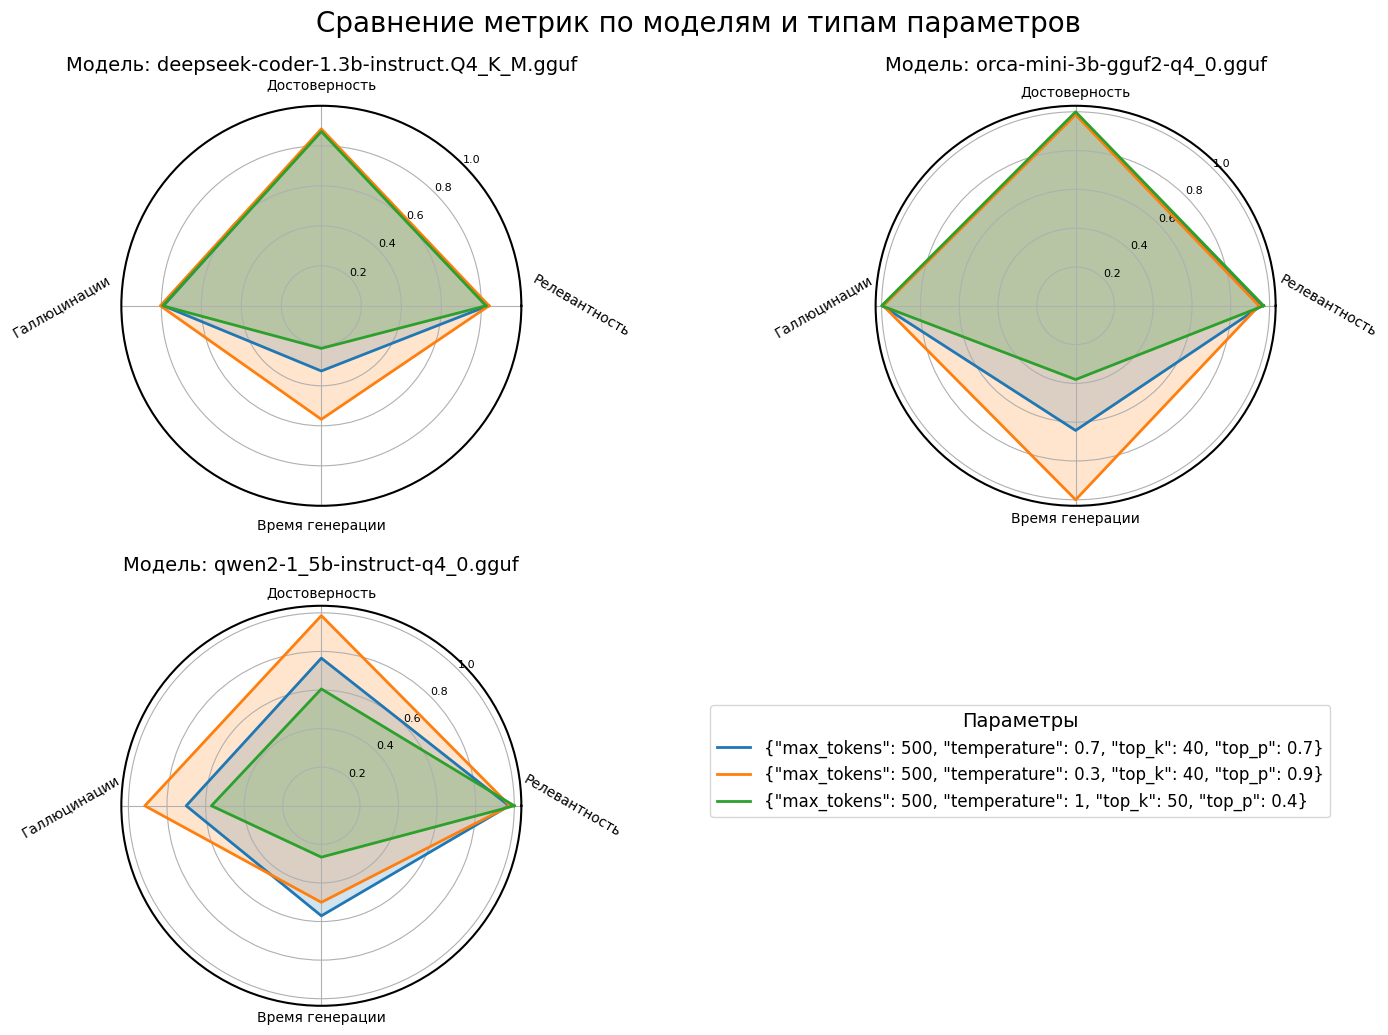

In [ ]:
grouped_df = results_df.merge(df[['parameters', 'question', 'answer', 'generation_time']],
                 how = 'outer' , on = ['parameters', 'question', 'answer']).groupby(['model_name', 'parameters'], as_index=False).agg({
    'faithfulness_score':'mean',
    'relevancy_score':'mean',
    'hallucination_score':'mean',
    'generation_time':'mean'
})

grouped_df.loc[grouped_df['parameters'] == 'conservative', 'params'] = '{"max_tokens": 500, "temperature": 0.3, "top_k": 40, "top_p": 0.9}'
grouped_df.loc[grouped_df['parameters'] == 'balanced', 'params'] = '{"max_tokens": 500, "temperature": 0.7, "top_k": 40, "top_p": 0.7}'
grouped_df.loc[grouped_df['parameters'] == 'creative', 'params'] = '{"max_tokens": 500, "temperature": 1, "top_k": 50, "top_p": 0.4}'

models = grouped_df['model_name'].unique()
params = grouped_df['params'].unique()

# Увеличиваем общий размер фигуры
fig = plt.figure(figsize=(16, 12)) 

# Настраиваем сетку графиков с меньшими отступами
num_models = len(models)
rows = (num_models + 1) // 2  # Количество строк для графиков

# Категории для лучей диаграммы
categories = ['Релевантность', 'Достоверность', 'Галлюцинации', 'Время генерации']
num_cats = len(categories)
angles = np.linspace(0, 2 * np.pi, num_cats, endpoint=False).tolist()
angles += angles[:1]  # Замыкаем круг

# Для общей легенды
param_lines = []
param_labels = []

# Создаем сетку для размещения графиков с указанием пропорций
gs = fig.add_gridspec(rows, 2, wspace=0.1, hspace=0.25, 
                      left=0.05, right=0.95, bottom=0.15, top=0.9)

# Добавляем общий заголовок
fig.suptitle('Сравнение метрик по моделям и типам параметров', fontsize=20, y=0.98)

for i, model in enumerate(models):
    row_idx = i // 2
    col_idx = i % 2
    
    # Используем gridspec для более точного контроля над размерами графиков
    ax = fig.add_subplot(gs[row_idx, col_idx], polar=True)
    
    for j, param in enumerate(params):
        data = grouped_df[(grouped_df['model_name'] == model) & (grouped_df['params'] == param)]
        if not data.empty:
            values = [
                data['relevancy_score'].values[0],
                data['faithfulness_score'].values[0],
                data['hallucination_score'].values[0],
                data['generation_time'].values[0]
            ]
            max_values = grouped_df[['relevancy_score', 'faithfulness_score', 'hallucination_score', 'generation_time']].max()
            normalized_values = [v / m for v, m in zip(values, max_values)]
            normalized_values += normalized_values[:1]  # Замыкаем значения
            
            # Рисуем линию и заливку
            line, = ax.plot(angles, normalized_values, linewidth=2)
            ax.fill(angles, normalized_values, alpha=0.2)
            
            # Сохраняем для легенды только один раз
            if i == 0:
                param_lines.append(line)
                param_labels.append(param)
    
    # Настройка меток осей
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    
    # Размещаем метки категорий с лучшим позиционированием
    ax.text(0, 1.3, 'Релевантность', ha='center', va='center', fontsize=10, rotation=-30, rotation_mode='anchor')
    ax.text(np.pi/2, 1.1, 'Достоверность', ha='center', va='center', fontsize=10)
    ax.text(np.pi, 1.3, 'Галлюцинации', ha='center', va='center', fontsize=10, rotation=30, rotation_mode='anchor')
    ax.text(3*np.pi/2, 1.1, 'Время генерации', ha='center', va='center', fontsize=10)
    
    # Название модели более компактно
    ax.set_title(f'Модель: {model}', pad=25, fontsize=14)
    
    # Настройка радиальных линий и концентрических кругов
    gridlines, labels = ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0], angle=45, fontsize=8)
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# Размещаем легенду внизу по центру для лучшего использования пространства
fig.legend(param_lines, param_labels, loc='lower right', bbox_to_anchor=(0.9, 0.3), fontsize=12, title="Параметры", title_fontsize=14)

plt.show()

In [3]:
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from langchain_ollama import OllamaEmbeddings, OllamaLLM
import time

# Загрузка результатов RAG-моделей
df_results = pd.concat([
    pd.read_csv('rag_model_evaluation_results_orca.csv'),
    pd.read_csv('rag_model_evaluation_results_phi.csv'),
    pd.read_csv('rag_model_evaluation_results_deepseek.csv')
]).reset_index(drop=True)

# Загрузка эталонных ответов
df_ground_truth = pd.read_csv('qdrant_documentation_dataset.csv')

# Объединение по 'question' для добавления эталонного ответа
df = pd.merge(df_results, df_ground_truth[['question', 'answer']], on='question', suffixes=('', '_ground_truth'))

# Переименование колонок под формат, понятный ragas
df.rename(columns={
    'answer': 'response',
    'answer_ground_truth': 'reference',
    'context': 'contexts'
}, inplace=True)

# Заполнить пропуски и преобразовать контекст в список строк
df['contexts'] = df['contexts'].fillna('').apply(lambda x: [x] if isinstance(x, str) and x.strip() else [])
df['question'] = df['question'].fillna('')
df['response'] = df['response'].fillna('')
df['reference'] = df['reference'].fillna('')

# Проверка на наличие пустых значений
print("Пустые значения:\n", df[['question', 'response', 'reference', 'contexts']].isnull().sum())
llm = OllamaLLM(model="llama3.2")
embeddings = OllamaEmbeddings(model="llama3.2")

# Подготовка датасета
data_full = Dataset.from_pandas(df[['question', 'response', 'reference', 'contexts']])

# Параметры
BATCH_SIZE = 5       # количество вопросов в одном большом пакете
MINI_BATCH_SIZE = 1  # сколько вопросов обрабатывать за раз внутри пакета
SLEEP_TIME = 5       # время ожидания в секундах между мини-пакетами
output_file = "rag_evaluation_results_llama3_2.csv"

df_result = pd.DataFrame()

for i in range(0, len(data_full), BATCH_SIZE):
    print(f"\nОбработка основного пакета {i // BATCH_SIZE + 1} (записи {i}–{min(i + BATCH_SIZE, len(data_full))})...")

    # Выбираем часть датасета как "основной пакет"
    data_batch = data_full.select(range(i, min(i + BATCH_SIZE, len(data_full))))

    mini_df_result = pd.DataFrame()  # результаты текущего большого пакета

    # Разбиваем основной пакет на мини-пакеты
    for j in range(0, len(data_batch), MINI_BATCH_SIZE):
        print(f"  └─ Обработка мини-пакета {j // MINI_BATCH_SIZE + 1} (внутри основного)")
        
        data_mini_batch = data_batch.select(range(j, min(j + MINI_BATCH_SIZE, len(data_batch))))

        try:
            result_mini_batch = evaluate(
                data_mini_batch,
                metrics=[
                    faithfulness,
                    answer_relevancy,
                    context_precision,
                    context_recall
                ],
                llm=llm,
                embeddings=embeddings
            )

            df_mini = result_mini_batch.to_pandas()
            df_mini['question'] = data_mini_batch['question']
            df_mini['response'] = data_mini_batch['response']
            df_mini['reference'] = data_mini_batch['reference']

            mini_df_result = pd.concat([mini_df_result, df_mini], ignore_index=True)

        except Exception as e:
            print(f"    ❌ Ошибка при обработке мини-пакета: {e}")

        # Задержка после каждого мини-пакета
        print(f"  ⏳ Жду {SLEEP_TIME} секунд перед следующей попыткой...")
        time.sleep(SLEEP_TIME)

    # Добавляем результаты основного пакета к общему DataFrame
    df_result = pd.concat([df_result, mini_df_result], ignore_index=True)

    # Сохраняем всё состояние в файл
    df_result.to_csv(output_file, index=False)
    print(f"✅ Сохранено в CSV: {output_file}")

Пустые значения:
 question     0
response     0
reference    0
contexts     0
dtype: int64

Обработка основного пакета 1 (записи 0–5)...
  └─ Обработка мини-пакета 1 (внутри основного)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()


  ⏳ Жду 5 секунд перед следующей попыткой...
  └─ Обработка мини-пакета 2 (внутри основного)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()


  ⏳ Жду 5 секунд перед следующей попыткой...
  └─ Обработка мини-пакета 3 (внутри основного)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()


  ⏳ Жду 5 секунд перед следующей попыткой...
  └─ Обработка мини-пакета 4 (внутри основного)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()


  ⏳ Жду 5 секунд перед следующей попыткой...
  └─ Обработка мини-пакета 5 (внутри основного)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

Exception raised in Job[2]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()


Оценка ответов:   0%|          | 0/2943 [00:00<?, ?it/s]

Оценки для строки 0: Faithfulness=0.8, Relevancy=0.5, Hallucination=0.5
Оценки для строки 1: Faithfulness=0.5, Relevancy=0.8, Hallucination=0.83
Оценки для строки 2: Faithfulness=0.9, Relevancy=0.8, Hallucination=0.9
Оценки для строки 3: Faithfulness=0.8, Relevancy=0.3, Hallucination=0.8
Оценки для строки 4: Faithfulness=0.77, Relevancy=0.77, Hallucination=0.9
Оценки для строки 5: Faithfulness=0.9, Relevancy=0.8, Hallucination=0.9
Оценки для строки 6: Faithfulness=0.8, Relevancy=0.5, Hallucination=0.5
Оценки для строки 7: Faithfulness=0.8, Relevancy=0.3, Hallucination=0.5
Оценки для строки 8: Faithfulness=0.8, Relevancy=0.3, Hallucination=0.65
Оценки для строки 9: Faithfulness=0.8, Relevancy=0.3, Hallucination=0.5
Оценки для строки 10: Faithfulness=0.8, Relevancy=0.5, Hallucination=0.8
Оценки для строки 11: Faithfulness=0.8, Relevancy=0.3, Hallucination=0.67
Оценки для строки 12: Faithfulness=0.8, Relevancy=0.5, Hallucination=0.8
Оценки для строки 13: Faithfulness=0.8, Relevancy=0.8, H

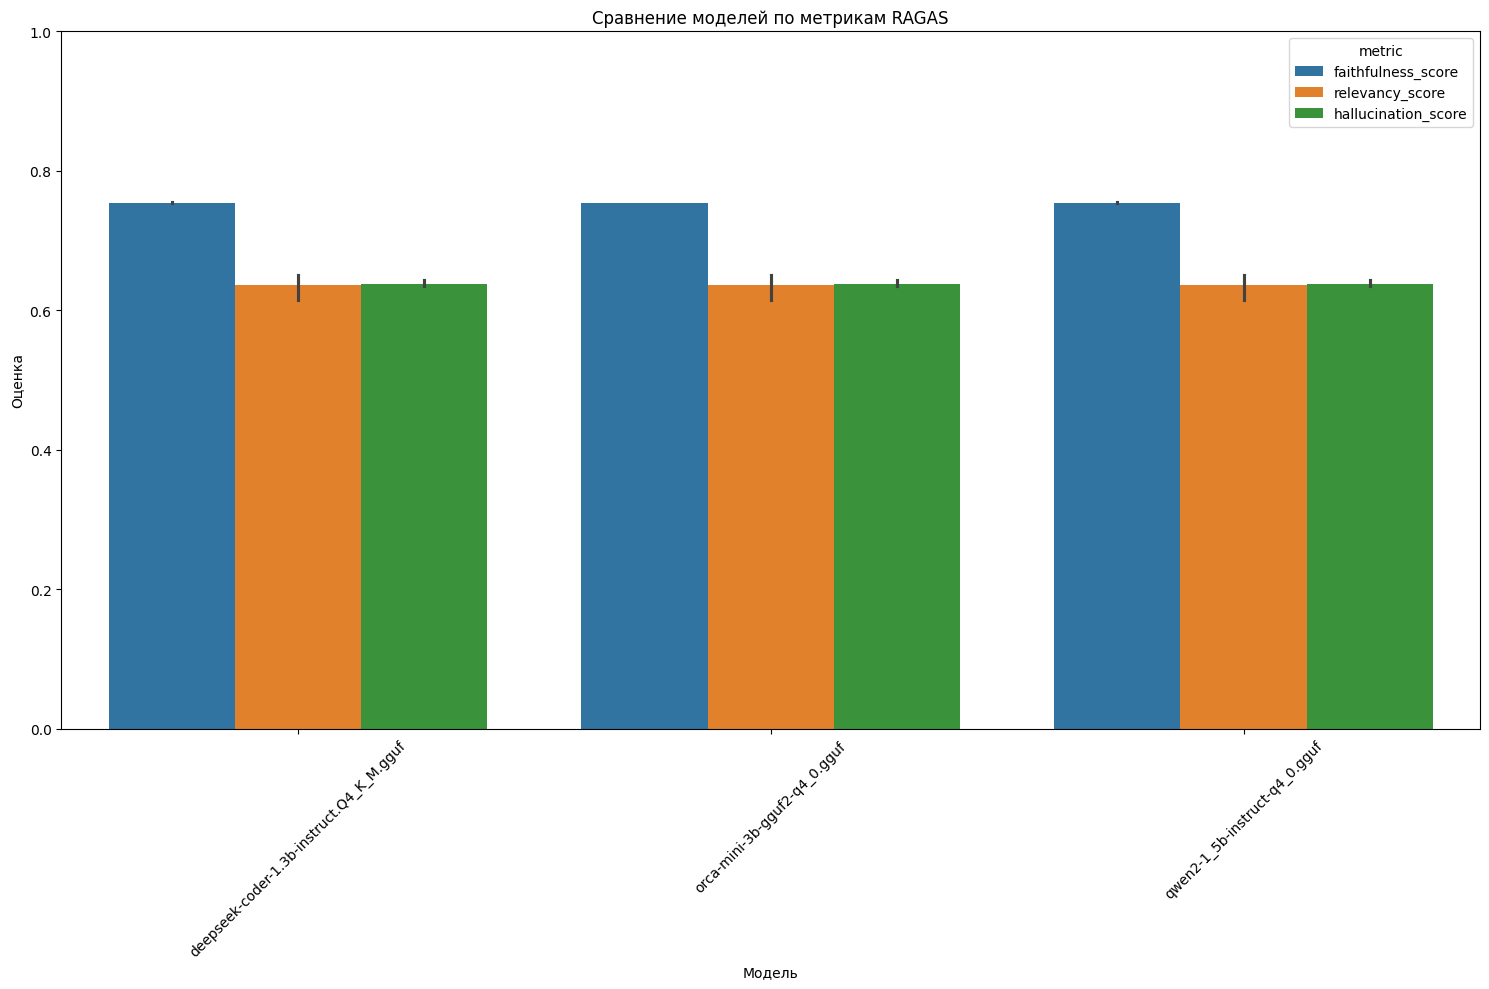

<Figure size 2000x1200 with 0 Axes>

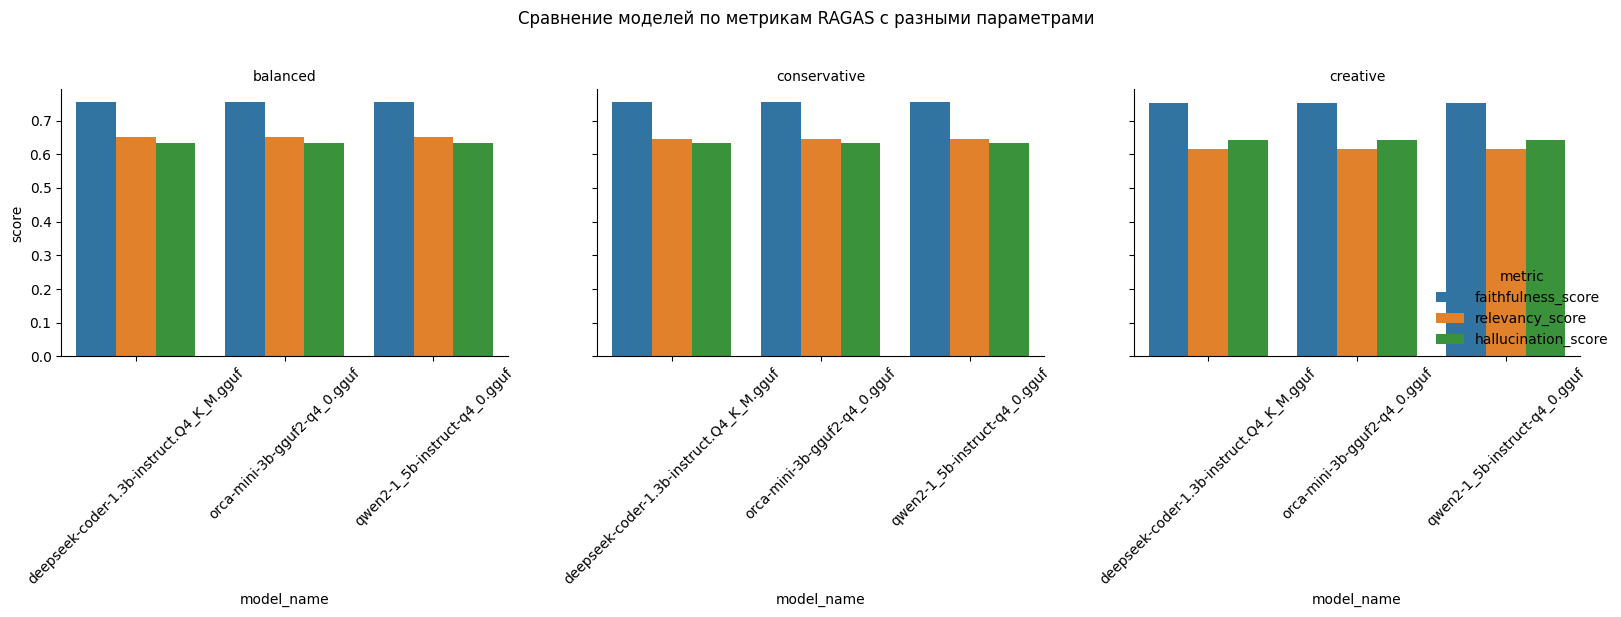

In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import json
from typing import List, Dict, Any, Optional
import requests
from dataclasses import dataclass, asdict
import re

# Загрузка данных
df = pd.concat([
    pd.read_csv('rag_model_evaluation_results_orca.csv'),
    pd.read_csv('rag_model_evaluation_results_phi.csv'),
    pd.read_csv('rag_model_evaluation_results_deepseek.csv')
])

# Загрузка корректных ответов
correct_answers_df = pd.read_csv('qdrant_documentation_dataset.csv')

# Функция для вызова локальной модели llama3.2 через ollama
def get_llm_response(prompt: str, 
                    temperature: float = 0.1, 
                    max_tokens: int = 2048) -> str:
    """
    Вызов локальной модели llama3.2 через ollama
    """
    url = "http://localhost:11434/api/generate"
    
    payload = {
        "model": "llama3.2",
        "prompt": prompt,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    
    response = requests.post(url, json=payload)
    
    if response.status_code == 200:
        return response.json()["response"]
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return ""

# Функция для извлечения числа из ответа, обрабатывающая как точки, так и запятые
def extract_float_from_response(response: str) -> float:
    """
    Извлекает числовое значение из ответа модели, поддерживая как точки, так и запятые
    в качестве десятичного разделителя.
    """
    # Очищаем ответ от пробелов и других символов
    cleaned_response = response.strip()
    
    # Пытаемся найти число с помощью регулярного выражения
    # Ищем числа вида 0.8 или 0,8
    match = re.search(r'(\d+[.,]\d+|\d+)', cleaned_response)
    if match:
        # Заменяем запятую на точку, если она есть
        number_str = match.group(0).replace(',', '.')
        try:
            return float(number_str)
        except ValueError:
            print(f"Не удалось преобразовать найденное число {number_str} в float")
            return np.nan
    
    print(f"Не удалось найти число в ответе: {response}")
    return np.nan

# Функция для оценки faithfulness (верность контексту)
def evaluate_faithfulness(answer: str, context: str) -> float:
    prompt = f"""Оцените, насколько ответ соответствует предоставленному контексту. 
    Faithfulness (верность) означает, что информация в ответе должна содержаться в исходном контексте, 
    и в ответе не должно быть добавлено никакой дополнительной или противоречащей информации.
    
    Контекст:
    {context}
    
    Ответ:
    {answer}
    
    Оцените faithfulness от 0 до 1, где:
    - 0: Ответ содержит информацию, которой нет в контексте, или противоречит контексту
    - 0.5: Ответ частично соответствует контексту, но имеет несколько утверждений, не подтвержденных контекстом
    - 1: Ответ полностью соответствует контексту и не содержит никакой информации, отсутствующей в контексте
    
    Дайте только числовую оценку без пояснений. Используйте точку в качестве десятичного разделителя, например, 0.7
    """
    
    response = get_llm_response(prompt)
    score = extract_float_from_response(response)
    return min(max(score, 0), 1) if not np.isnan(score) else np.nan

# Функция для оценки relevancy (релевантность ответа вопросу)
def evaluate_relevancy(question: str, answer: str) -> float:
    prompt = f"""Оцените, насколько ответ релевантен заданному вопросу.
    Вопрос:
    {question}
    
    Ответ:
    {answer}
    
    Оцените relevancy от 0 до 1, где:
    - 0: Ответ совершенно не относится к вопросу
    - 0.5: Ответ частично отвечает на вопрос, но упускает ключевые моменты или отвлекается на нерелевантную информацию
    - 1: Ответ полностью и точно отвечает на вопрос
    
    Дайте только числовую оценку без пояснений. Используйте точку в качестве десятичного разделителя, например, 0.7
    """
    
    response = get_llm_response(prompt)
    score = extract_float_from_response(response)
    return min(max(score, 0), 1) if not np.isnan(score) else np.nan

# Функция для оценки галлюцинаций
def evaluate_hallucination(answer: str, correct_answer: str, context: str) -> float:
    prompt = f"""Оцените, содержит ли ответ галлюцинации (выдуманную или неверную информацию).
    
    Контекст:
    {context}
    
    Правильный ответ:
    {correct_answer}
    
    Проверяемый ответ:
    {answer}
    
    Оцените hallucination_score от 0 до 1, где:
    - 0: Ответ содержит много галлюцинаций и выдуманной информации
    - 0.5: Ответ содержит несколько утверждений, которые можно считать галлюцинациями
    - 1: Ответ не содержит галлюцинаций и полностью соответствует фактам
    
    Дайте только числовую оценку без пояснений. Используйте точку в качестве десятичного разделителя, например, 0.7
    """
    
    response = get_llm_response(prompt)
    score = extract_float_from_response(response)
    return min(max(score, 0), 1) if not np.isnan(score) else np.nan

# Создаем словарь для быстрого доступа к правильным ответам
correct_answers_dict = dict(zip(correct_answers_df['question'], correct_answers_df['answer']))

# Создаем пустые столбцы для оценок
df['faithfulness_score'] = np.nan
df['relevancy_score'] = np.nan
df['hallucination_score'] = np.nan

# Оцениваем каждый ответ
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Оценка ответов"):
    question = row['question']
    answer = row['answer']
    context = row['context']
    
    # Получаем правильный ответ для этого вопроса
    correct_answer = correct_answers_dict.get(question, "")
    
    if not pd.isna(answer) and isinstance(answer, str) and len(answer) > 0:
        # Оцениваем faithfulness
        faithfulness = evaluate_faithfulness(answer, context)
        df.at[idx, 'faithfulness_score'] = faithfulness
        
        # Оцениваем relevancy
        relevancy = evaluate_relevancy(question, answer)
        df.at[idx, 'relevancy_score'] = relevancy
        
        # Оцениваем hallucination
        hallucination = evaluate_hallucination(answer, correct_answer, context)
        df.at[idx, 'hallucination_score'] = hallucination
        
        # Добавляем печать для информации о прогрессе
        print(f"Оценки для строки {idx}: Faithfulness={faithfulness}, Relevancy={relevancy}, Hallucination={hallucination}")
        
        # Сохраняем промежуточные результаты после каждых 5 оценок
        if idx % 5 == 0:
            df.to_csv('rag_evaluation_with_scores.csv', index=False)

# Сохраняем финальные результаты
df.to_csv('rag_evaluation_with_scores_final.csv', index=False)

# Расчет агрегированных метрик по моделям и параметрам
agg_results = df.groupby(['model_name', 'parameters'])[['faithfulness_score', 'relevancy_score', 'hallucination_score']].mean().reset_index()
print("\n--- Агрегированные результаты по моделям и параметрам ---")
print(agg_results)

# Визуализация результатов
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Мелтим данные для удобства визуализации
melted_results = pd.melt(agg_results, 
                        id_vars=['model_name', 'parameters'],
                        value_vars=['faithfulness_score', 'relevancy_score', 'hallucination_score'],
                        var_name='metric', value_name='score')

# Создаем график
sns.barplot(x='model_name', y='score', hue='metric', data=melted_results)
plt.title('Сравнение моделей по метрикам RAGAS')
plt.xlabel('Модель')
plt.ylabel('Оценка')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rag_models_comparison.png')
plt.show()

# Дополнительный график с разбивкой по параметрам
plt.figure(figsize=(20, 12))
g = sns.catplot(x='model_name', y='score', hue='metric', col='parameters',
               data=melted_results, kind='bar', height=6, aspect=0.8)
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.fig.suptitle('Сравнение моделей по метрикам RAGAS с разными параметрами', y=1.02)
plt.tight_layout()
plt.savefig('rag_models_comparison_by_parameters.png')
plt.show()

In [20]:
agg_results

,model_name,parameters,faithfulness_score,relevancy_score,hallucination_score
0,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,balanced,0.754869,0.650336,0.634070
1,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,conservative,0.753648,0.645040,0.634061
2,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,creative,0.753474,0.615116,0.642926
3,orca-mini-3b-gguf2-q4_0.gguf,balanced,0.754869,0.650336,0.634070
4,orca-mini-3b-gguf2-q4_0.gguf,conservative,0.753648,0.645040,0.634061
5,orca-mini-3b-gguf2-q4_0.gguf,creative,0.753474,0.615116,0.642926
6,qwen2-1_5b-instruct-q4_0.gguf,balanced,0.754869,0.650336,0.634070
7,qwen2-1_5b-instruct-q4_0.gguf,conservative,0.753648,0.645040,0.634061
8,qwen2-1_5b-instruct-q4_0.gguf,creative,0.753474,0.615116,0.642926


In [22]:
agg_results.loc[agg_results['parameters'] == 'conservative', 'parameters'] = '{"max_tokens": 500, "temperature": 0.3, "top_k": 40, "top_p": 0.9}'
agg_results.loc[agg_results['parameters'] == 'balanced', 'parameters'] = '{"max_tokens": 500, "temperature": 0.7, "top_k": 40, "top_p": 0.7}'
agg_results.loc[agg_results['parameters'] == 'creative', 'parameters'] = '{"max_tokens": 500, "temperature": 1, "top_k": 50, "top_p": 0.4}'

agg_results.loc[agg_results['model_name'] == 'deepseek-coder-1.3b-instruct.Q4_K_M.gguf', 'model_name'] = 'deepseek-coder-1.3b-instruct'
agg_results.loc[agg_results['model_name'] == 'orca-mini-3b-gguf2-q4_0.gguf', 'model_name'] = 'orca-mini-3b'
agg_results.loc[agg_results['model_name'] == 'qwen2-1_5b-instruct-q4_0.gguf', 'model_name'] = 'qwen2-1_5b-instruct'
agg_results.to_csv('agg_results.csv')

In [23]:
grouped_df

,model_name,parameters,faithfulness_score,relevancy_score,hallucination_score,generation_time,params
0,deepseek-coder-1.3b-instruct,balanced,0.754869,0.650336,0.634070,51.752105,"{""max_tokens"": 500, ""temperature"": 0.7, ""top_k..."
1,deepseek-coder-1.3b-instruct,conservative,0.753648,0.645040,0.634061,90.136833,"{""max_tokens"": 500, ""temperature"": 0.3, ""top_k..."
2,deepseek-coder-1.3b-instruct,creative,0.753474,0.615116,0.642926,33.817521,"{""max_tokens"": 500, ""temperature"": 1, ""top_k"":..."
3,orca-mini-3b,balanced,0.754869,0.650336,0.634070,102.016491,"{""max_tokens"": 500, ""temperature"": 0.7, ""top_k..."
4,orca-mini-3b,conservative,0.753648,0.645040,0.634061,158.751920,"{""max_tokens"": 500, ""temperature"": 0.3, ""top_k..."
5,orca-mini-3b,creative,0.753474,0.615116,0.642926,60.353307,"{""max_tokens"": 500, ""temperature"": 1, ""top_k"":..."
6,qwen2-1_5b-instruct,balanced,0.754869,0.650336,0.634070,90.542581,"{""max_tokens"": 500, ""temperature"": 0.7, ""top_k..."
7,qwen2-1_5b-instruct,conservative,0.753648,0.645040,0.634061,79.452444,"{""max_tokens"": 500, ""temperature"": 0.3, ""top_k..."
8,qwen2-1_5b-instruct,creative,0.753474,0.615116,0.642926,42.271225,"{""max_tokens"": 500, ""temperature"": 1, ""top_k"":..."


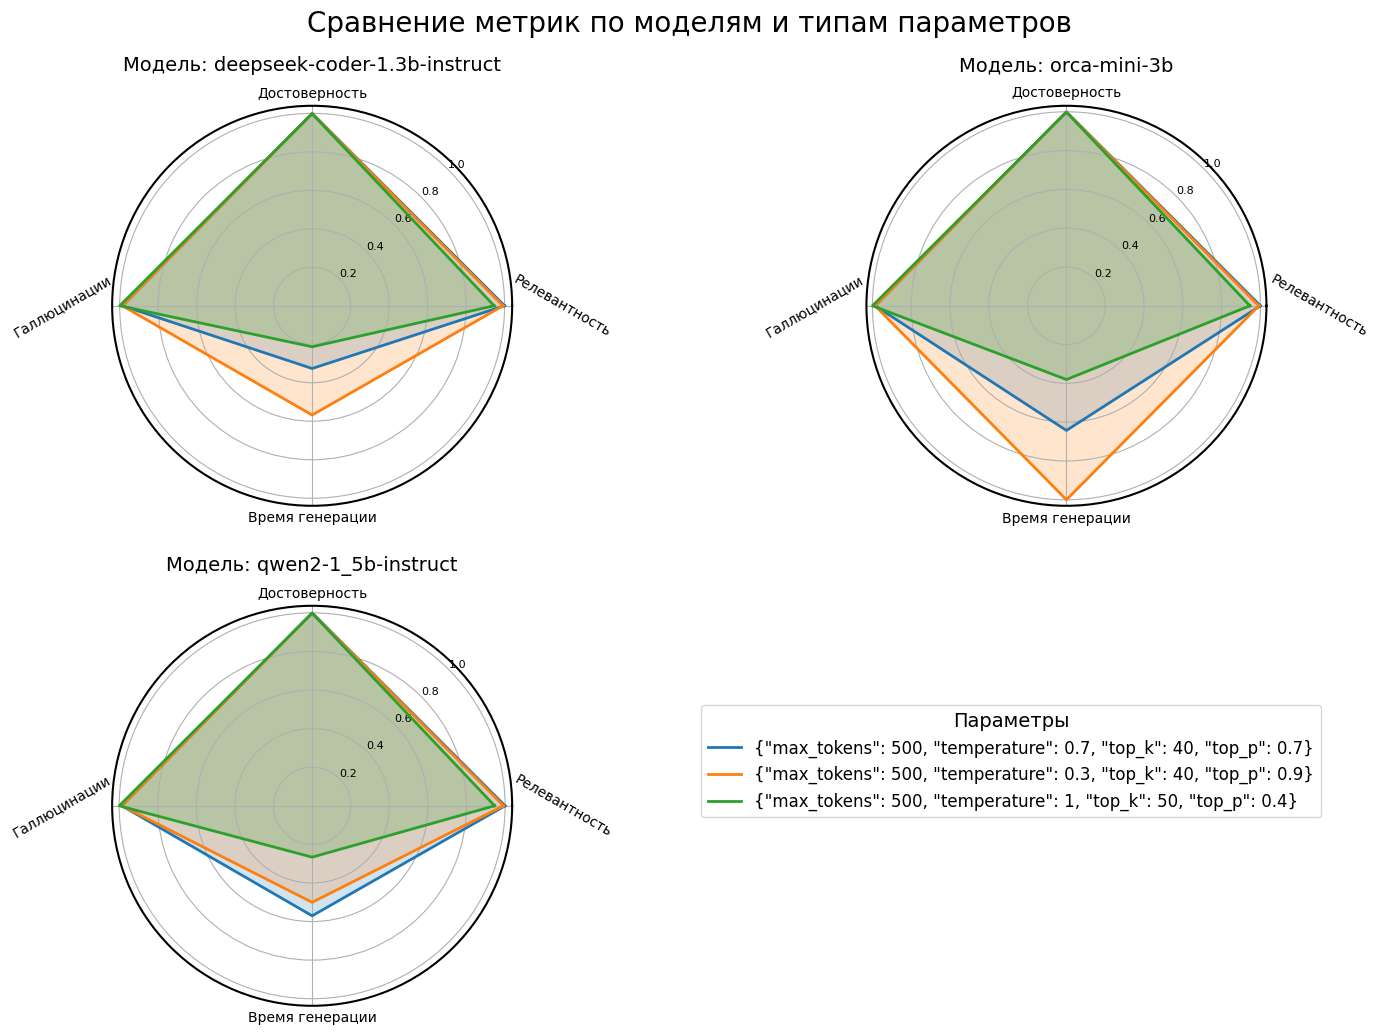

In [18]:
grouped_df = pd.read_csv('rag_evaluation_with_scores_final.csv').groupby(['model_name', 'parameters'], as_index=False).agg({
    'faithfulness_score':'mean',
    'relevancy_score':'mean',
    'hallucination_score':'mean',
    'generation_time':'mean'
})

grouped_df.loc[grouped_df['parameters'] == 'conservative', 'params'] = '{"max_tokens": 500, "temperature": 0.3, "top_k": 40, "top_p": 0.9}'
grouped_df.loc[grouped_df['parameters'] == 'balanced', 'params'] = '{"max_tokens": 500, "temperature": 0.7, "top_k": 40, "top_p": 0.7}'
grouped_df.loc[grouped_df['parameters'] == 'creative', 'params'] = '{"max_tokens": 500, "temperature": 1, "top_k": 50, "top_p": 0.4}'

grouped_df.loc[grouped_df['model_name'] == 'deepseek-coder-1.3b-instruct.Q4_K_M.gguf', 'model_name'] = 'deepseek-coder-1.3b-instruct'
grouped_df.loc[grouped_df['model_name'] == 'orca-mini-3b-gguf2-q4_0.gguf', 'model_name'] = 'orca-mini-3b'
grouped_df.loc[grouped_df['model_name'] == 'qwen2-1_5b-instruct-q4_0.gguf', 'model_name'] = 'qwen2-1_5b-instruct'

models = grouped_df['model_name'].unique()
params = grouped_df['params'].unique()

# Увеличиваем общий размер фигуры
fig = plt.figure(figsize=(16, 12)) 

# Настраиваем сетку графиков с меньшими отступами
num_models = len(models)
rows = (num_models + 1) // 2  # Количество строк для графиков

# Категории для лучей диаграммы
categories = ['Релевантность', 'Достоверность', 'Галлюцинации', 'Время генерации']
num_cats = len(categories)
angles = np.linspace(0, 2 * np.pi, num_cats, endpoint=False).tolist()
angles += angles[:1]  # Замыкаем круг

# Для общей легенды
param_lines = []
param_labels = []

# Создаем сетку для размещения графиков с указанием пропорций
gs = fig.add_gridspec(rows, 2, wspace=0.1, hspace=0.25, 
                      left=0.05, right=0.95, bottom=0.15, top=0.9)

# Добавляем общий заголовок
fig.suptitle('Сравнение метрик по моделям и типам параметров', fontsize=20, y=0.98)

for i, model in enumerate(models):
    row_idx = i // 2
    col_idx = i % 2
    
    # Используем gridspec для более точного контроля над размерами графиков
    ax = fig.add_subplot(gs[row_idx, col_idx], polar=True)
    
    for j, param in enumerate(params):
        data = grouped_df[(grouped_df['model_name'] == model) & (grouped_df['params'] == param)]
        if not data.empty:
            values = [
                data['relevancy_score'].values[0],
                data['faithfulness_score'].values[0],
                data['hallucination_score'].values[0],
                data['generation_time'].values[0]
            ]
            max_values = grouped_df[['relevancy_score', 'faithfulness_score', 'hallucination_score', 'generation_time']].max()
            normalized_values = [v / m for v, m in zip(values, max_values)]
            normalized_values += normalized_values[:1]  # Замыкаем значения
            
            # Рисуем линию и заливку
            line, = ax.plot(angles, normalized_values, linewidth=2)
            ax.fill(angles, normalized_values, alpha=0.2)
            
            # Сохраняем для легенды только один раз
            if i == 0:
                param_lines.append(line)
                param_labels.append(param)
    
    # Настройка меток осей
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    
    # Размещаем метки категорий с лучшим позиционированием
    ax.text(0, 1.3, 'Релевантность', ha='center', va='center', fontsize=10, rotation=-30, rotation_mode='anchor')
    ax.text(np.pi/2, 1.1, 'Достоверность', ha='center', va='center', fontsize=10)
    ax.text(np.pi, 1.3, 'Галлюцинации', ha='center', va='center', fontsize=10, rotation=30, rotation_mode='anchor')
    ax.text(3*np.pi/2, 1.1, 'Время генерации', ha='center', va='center', fontsize=10)
    
    # Название модели более компактно
    ax.set_title(f'Модель: {model}', pad=25, fontsize=14)
    
    # Настройка радиальных линий и концентрических кругов
    gridlines, labels = ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0], angle=45, fontsize=8)
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# Размещаем легенду внизу по центру для лучшего использования пространства
fig.legend(param_lines, param_labels, loc='lower right', bbox_to_anchor=(0.9, 0.3), fontsize=12, title="Параметры", title_fontsize=14)

plt.show()

Оценка ответов:   0%|          | 0/1308 [00:00<?, ?it/s]

Оценки для строки 0: Faithfulness=0.8, Relevancy=0.5, Hallucination=0.8
Оценки для строки 1: Faithfulness=0.8, Relevancy=0.8, Hallucination=0.8
Оценки для строки 2: Faithfulness=0.8, Relevancy=0.8, Hallucination=0.8
Оценки для строки 3: Faithfulness=0.8, Relevancy=0.3, Hallucination=0.8
Оценки для строки 4: Faithfulness=0.8, Relevancy=0.8, Hallucination=0.8
Оценки для строки 5: Faithfulness=0.9, Relevancy=0.8, Hallucination=0.3
Оценки для строки 6: Faithfulness=0.5, Relevancy=0.5, Hallucination=0.8
Оценки для строки 7: Faithfulness=0.73, Relevancy=0.5, Hallucination=0.8
Оценки для строки 8: Faithfulness=0.8, Relevancy=0.8, Hallucination=0.8
Оценки для строки 9: Faithfulness=0.83, Relevancy=0.2, Hallucination=0.8
Оценки для строки 10: Faithfulness=0.86, Relevancy=0.8, Hallucination=0.8
Оценки для строки 11: Faithfulness=0.8, Relevancy=0.8, Hallucination=0.8
Оценки для строки 12: Faithfulness=0.86, Relevancy=0.685972431, Hallucination=0.8
Оценки для строки 13: Faithfulness=0.8, Relevancy

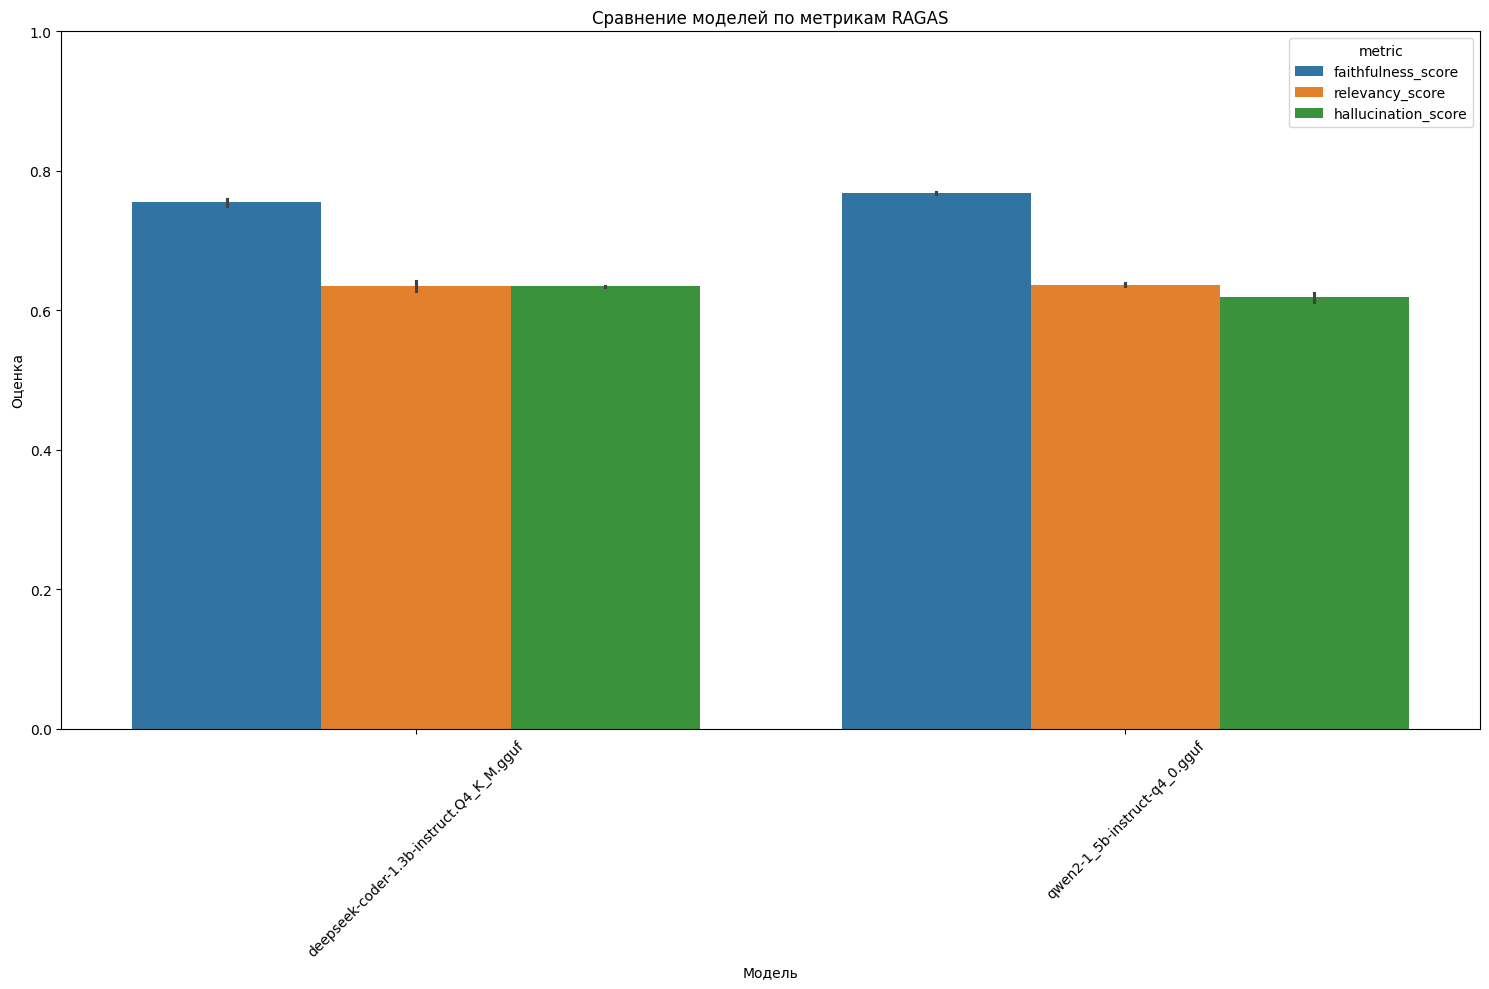

<Figure size 2000x1200 with 0 Axes>

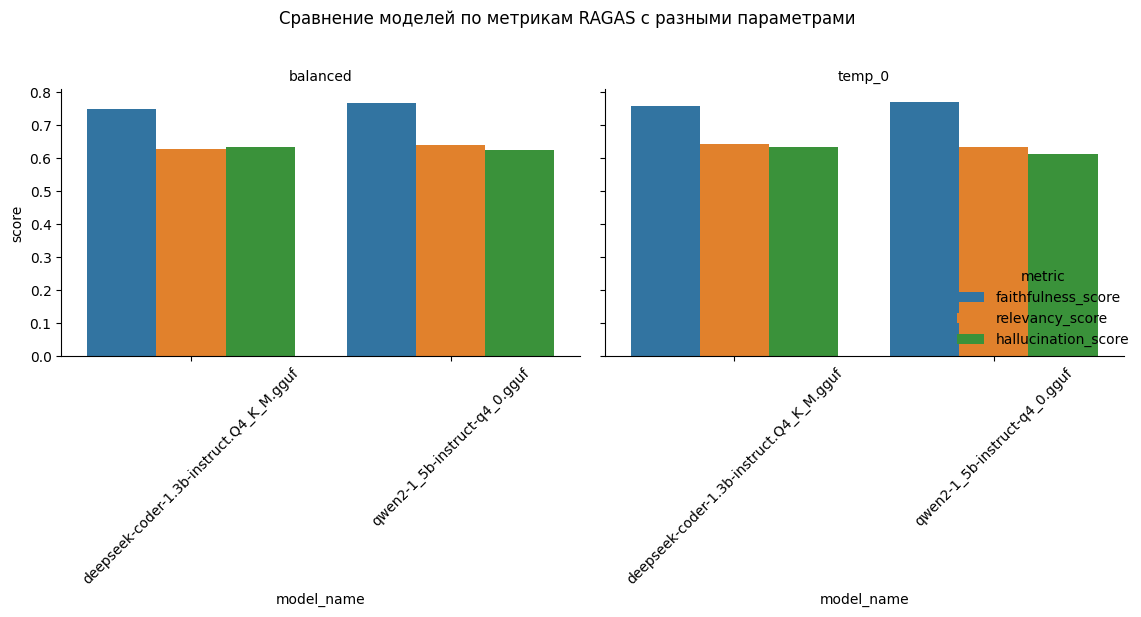

In [24]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import json
from typing import List, Dict, Any, Optional
import requests
from dataclasses import dataclass, asdict
import re

# Загрузка данных
df = pd.read_csv('rag_model_generation_results_seria2.csv')

# Загрузка корректных ответов
correct_answers_df = pd.read_csv('qdrant_documentation_dataset.csv')

# Функция для вызова локальной модели llama3.2 через ollama
def get_llm_response(prompt: str, 
                    temperature: float = 0.1, 
                    max_tokens: int = 2048) -> str:
    """
    Вызов локальной модели llama3.2 через ollama
    """
    url = "http://localhost:11434/api/generate"
    
    payload = {
        "model": "llama3.2",
        "prompt": prompt,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    
    response = requests.post(url, json=payload)
    
    if response.status_code == 200:
        return response.json()["response"]
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return ""

# Функция для извлечения числа из ответа, обрабатывающая как точки, так и запятые
def extract_float_from_response(response: str) -> float:
    """
    Извлекает числовое значение из ответа модели, поддерживая как точки, так и запятые
    в качестве десятичного разделителя.
    """
    # Очищаем ответ от пробелов и других символов
    cleaned_response = response.strip()
    
    # Пытаемся найти число с помощью регулярного выражения
    # Ищем числа вида 0.8 или 0,8
    match = re.search(r'(\d+[.,]\d+|\d+)', cleaned_response)
    if match:
        # Заменяем запятую на точку, если она есть
        number_str = match.group(0).replace(',', '.')
        try:
            return float(number_str)
        except ValueError:
            print(f"Не удалось преобразовать найденное число {number_str} в float")
            return np.nan
    
    print(f"Не удалось найти число в ответе: {response}")
    return np.nan

# Функция для оценки faithfulness (верность контексту)
def evaluate_faithfulness(answer: str, context: str) -> float:
    prompt = f"""Оцените, насколько ответ соответствует предоставленному контексту. 
    Faithfulness (верность) означает, что информация в ответе должна содержаться в исходном контексте, 
    и в ответе не должно быть добавлено никакой дополнительной или противоречащей информации.
    
    Контекст:
    {context}
    
    Ответ:
    {answer}
    
    Оцените faithfulness от 0 до 1, где:
    - 0: Ответ содержит информацию, которой нет в контексте, или противоречит контексту
    - 0.5: Ответ частично соответствует контексту, но имеет несколько утверждений, не подтвержденных контекстом
    - 1: Ответ полностью соответствует контексту и не содержит никакой информации, отсутствующей в контексте
    
    Дайте только числовую оценку без пояснений. Используйте точку в качестве десятичного разделителя, например, 0.7
    """
    
    response = get_llm_response(prompt)
    score = extract_float_from_response(response)
    return min(max(score, 0), 1) if not np.isnan(score) else np.nan

# Функция для оценки relevancy (релевантность ответа вопросу)
def evaluate_relevancy(question: str, answer: str) -> float:
    prompt = f"""Оцените, насколько ответ релевантен заданному вопросу.
    Вопрос:
    {question}
    
    Ответ:
    {answer}
    
    Оцените relevancy от 0 до 1, где:
    - 0: Ответ совершенно не относится к вопросу
    - 0.5: Ответ частично отвечает на вопрос, но упускает ключевые моменты или отвлекается на нерелевантную информацию
    - 1: Ответ полностью и точно отвечает на вопрос
    
    Дайте только числовую оценку без пояснений. Используйте точку в качестве десятичного разделителя, например, 0.7
    """
    
    response = get_llm_response(prompt)
    score = extract_float_from_response(response)
    return min(max(score, 0), 1) if not np.isnan(score) else np.nan

# Функция для оценки галлюцинаций
def evaluate_hallucination(answer: str, correct_answer: str, context: str) -> float:
    prompt = f"""Оцените, содержит ли ответ галлюцинации (выдуманную или неверную информацию).
    
    Контекст:
    {context}
    
    Правильный ответ:
    {correct_answer}
    
    Проверяемый ответ:
    {answer}
    
    Оцените hallucination_score от 0 до 1, где:
    - 0: Ответ содержит много галлюцинаций и выдуманной информации
    - 0.5: Ответ содержит несколько утверждений, которые можно считать галлюцинациями
    - 1: Ответ не содержит галлюцинаций и полностью соответствует фактам
    
    Дайте только числовую оценку без пояснений. Используйте точку в качестве десятичного разделителя, например, 0.7
    """
    
    response = get_llm_response(prompt)
    score = extract_float_from_response(response)
    return min(max(score, 0), 1) if not np.isnan(score) else np.nan

# Создаем словарь для быстрого доступа к правильным ответам
correct_answers_dict = dict(zip(correct_answers_df['question'], correct_answers_df['answer']))

# Создаем пустые столбцы для оценок
df['faithfulness_score'] = np.nan
df['relevancy_score'] = np.nan
df['hallucination_score'] = np.nan

# Оцениваем каждый ответ
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Оценка ответов"):
    question = row['question']
    answer = row['answer']
    context = row['context']
    
    # Получаем правильный ответ для этого вопроса
    correct_answer = correct_answers_dict.get(question, "")
    
    if not pd.isna(answer) and isinstance(answer, str) and len(answer) > 0:
        # Оцениваем faithfulness
        faithfulness = evaluate_faithfulness(answer, context)
        df.at[idx, 'faithfulness_score'] = faithfulness
        
        # Оцениваем relevancy
        relevancy = evaluate_relevancy(question, answer)
        df.at[idx, 'relevancy_score'] = relevancy
        
        # Оцениваем hallucination
        hallucination = evaluate_hallucination(answer, correct_answer, context)
        df.at[idx, 'hallucination_score'] = hallucination
        
        # Добавляем печать для информации о прогрессе
        print(f"Оценки для строки {idx}: Faithfulness={faithfulness}, Relevancy={relevancy}, Hallucination={hallucination}")
        
        # Сохраняем промежуточные результаты после каждых 5 оценок
        if idx % 5 == 0:
            df.to_csv('rag_evaluation_with_scores_ser2.csv', index=False)

# Сохраняем финальные результаты
df.to_csv('rag_evaluation_with_scores_final_ser2.csv', index=False)

# Расчет агрегированных метрик по моделям и параметрам
agg_results = df.groupby(['model_name', 'parameters'])[['faithfulness_score', 'relevancy_score', 'hallucination_score']].mean().reset_index()
print("\n--- Агрегированные результаты по моделям и параметрам ---")
print(agg_results)

# Визуализация результатов
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Мелтим данные для удобства визуализации
melted_results = pd.melt(agg_results, 
                        id_vars=['model_name', 'parameters'],
                        value_vars=['faithfulness_score', 'relevancy_score', 'hallucination_score'],
                        var_name='metric', value_name='score')

# Создаем график
sns.barplot(x='model_name', y='score', hue='metric', data=melted_results)
plt.title('Сравнение моделей по метрикам RAGAS')
plt.xlabel('Модель')
plt.ylabel('Оценка')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rag_models_comparison.png')
plt.show()

# Дополнительный график с разбивкой по параметрам
plt.figure(figsize=(20, 12))
g = sns.catplot(x='model_name', y='score', hue='metric', col='parameters',
               data=melted_results, kind='bar', height=6, aspect=0.8)
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.fig.suptitle('Сравнение моделей по метрикам RAGAS с разными параметрами', y=1.02)
plt.tight_layout()
plt.savefig('rag_models_comparison_by_parameters.png')
plt.show()

In [26]:
agg_results

,model_name,parameters,faithfulness_score,relevancy_score,hallucination_score
0,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,balanced,0.749722,0.628122,0.633997
1,deepseek-coder-1.3b-instruct.Q4_K_M.gguf,temp_0,0.759453,0.641859,0.634341
2,qwen2-1_5b-instruct-q4_0.gguf,balanced,0.766471,0.639404,0.624061
3,qwen2-1_5b-instruct-q4_0.gguf,temp_0,0.769902,0.634122,0.612509
